In [3]:
%load_ext autoreload
%autoreload 2
import os, sys
import collections
import re
import numpy as np
import json
import pandas as pd

# basedir = "/cbscratch/franco/trans-eqtl/simulation/ldpruned2/15064_450_10_800_30_100_100_0.01_0.5_0.0_1.0_0.6_4.0_0.1_20_0.02/"
# basedir = "/cbscratch/franco/trans-eqtl/simulation/ldpruned_saikat_bg/12639_450_10_800_30_100_100_0.01_0.5_0.0_1.0_0.6_4.0_0.1_20_0.02/"
basedir = "/cbscratch/franco/trans-eqtl/simulation/gtex_v6_ldpruned/12639_450_10_800_30_100_100_0.01_0.5_0.0_1.0_0.6_4.0_0.1_20_0.02/"

In [4]:
# load simulation data. We need:
# - trans-eqtl SNPs
# - trans-eqtl cis target gene
# - trans-eqtl trans target genes

def read_simtrans(transfile):
    res_dict = collections.defaultdict(dict)
    with open(transfile) as instream:
        for line in instream:
            arr = line.strip().split()
            snpid = arr[1]
            cisgene = arr[3]
            translist = arr[4].split(",")
            transgenes = ["ENSG{:06d}".format(int(x)) for x in translist]
            res_dict[snpid]["targets"] = transgenes
            res_dict[snpid]["cistarget"] = cisgene
    return res_dict


In [5]:
# TARGGEN_FIELDS = ['ensembl_id', 'pval']
# class TargGen(collections.namedtuple('_TargGen', TARGGEN_FIELDS)):
#     __slots__ = ()

simname = "sim001"
trans_dict = dict()    
simdir = os.path.join(basedir, simname)    
transfile = os.path.join(simdir, "input", "expression.trans")
trans_dict = read_simtrans(transfile)

In [6]:
genepos_file = os.path.join(simdir, "input", "expression.genepos")
genotype_file = os.path.join(simdir, "input", "genotype.dosage.txt")

def map_cis_genes(genepos_file, genotype_file):
    genelist = list()
    snplist  = list()
    cis_dict = dict()
    with open(genepos_file) as fin:
        next(fin)
        for line in fin:
            genelist.append(line.rstrip().split()[0])
    with open(genotype_file) as fin:
        for line in fin:
            snplist.append(line.rstrip().split()[1])
    if len(genelist) == len(snplist):
        cis_dict = dict(zip(snplist, genelist))
    else:
        print("Error, gene and snp numbers are not equal")
        raise
    return cis_dict

cis_dict = map_cis_genes(genepos_file, genotype_file)

In [7]:
def load_transtarget_genes(simdir, paramsdir, mode):
    target_genes_pvals = collections.defaultdict(lambda: collections.defaultdict(dict))
    target_gene_dir = os.path.join(simdir, paramsdir)
    if mode == "knn":
        # targfiles = [os.path.join(target_gene_dir,x) for x in os.listdir(target_gene_dir) if x.endswith("gene_snp_list_knn.txt")]
        targfile = os.path.join(target_gene_dir,"gene_snp_list_knn.txt")
    if mode == "cclm":
        targfile = os.path.join(target_gene_dir,"gene_snp_list.txt")
    if mode == "jpa":
        targfile = os.path.join(target_gene_dir,"all_gene_snp_list.txt")
#     for ff in targfiles:
    if os.path.exists(targfile):
        with open(targfile) as fin:
            next(fin)
            for line in fin:
                arr = line.split("\t")
                variant_id = arr[1]
                ensembl_id = arr[0]
                pval = float(arr[2])
                target_genes_pvals[variant_id][ensembl_id] = pval
    else:
        print("file not found", targfile)
    return target_genes_pvals

def load_rr_result(simdir, paramsdir):
    trans_eqtls_dict = collections.defaultdict(lambda: collections.defaultdict(dict))
    ff = os.path.join(simdir, paramsdir, "rr.txt")
    if os.path.exists(ff):
        with open(ff) as fin:
            next(fin)
            for line in fin:
                arr = line.split("\t")
                snp = arr[0]
                maf = float(arr[3])
                pval = float(arr[7])
                trans_eqtls_dict[snp]["pval"] = pval
                trans_eqtls_dict[snp]["maf"] = pval
    else:
        print("Error, file does not exist")
        raise
    return trans_eqtls_dict

def load_jpa_result(simdir, paramsdir):
    trans_eqtls_dict = collections.defaultdict(lambda: collections.defaultdict(dict))
    ff = os.path.join(simdir, paramsdir, "all_jpa.txt")
    if os.path.exists(ff):
        with open(ff) as fin:
            next(fin)
            for line in fin:
                arr = line.split("\t")
                snp = arr[0]
                jpa = float(arr[1])
                pval = float(arr[2])
                trans_eqtls_dict[snp]["pval"] = pval
    else:
        print("Error, file does not exist")
        raise
    return trans_eqtls_dict

def load_meqtl_result(simdir, paramsdir):
    trans_eqtls_dict = collections.defaultdict(lambda: collections.defaultdict(dict))
    ff = os.path.join(simdir, paramsdir, "trans_eqtl.txt")
    if os.path.exists(ff):
        with open(ff) as fin:
            next(fin)
            for line in fin:
                arr = line.split("\t")
                snp = arr[0]
                geneid = arr[1]
                pval = float(arr[4])
                fdr  = float(arr[5])
                if snp in trans_eqtls_dict:
                    continue
                trans_eqtls_dict[snp]["pval"] = pval
                trans_eqtls_dict[snp]["fdr"]  = fdr
    else:
        print("Error, file does not exist")
        raise
    return trans_eqtls_dict

def load_meqtl_targetgenes(simdir, paramsdir):
    target_genes_pvals = collections.defaultdict(lambda: collections.defaultdict(dict))
    ff = os.path.join(simdir, paramsdir, "trans_eqtl.txt")
    if os.path.exists(ff):
        with open(ff) as fin:
            next(fin)
            for line in fin:
                arr = line.split("\t")
                snp = arr[0]
                geneid = arr[1]
                pval = float(arr[4])
                fdr  = float(arr[5])
                target_genes_pvals[snp][geneid] = pval
    else:
        print("Error, file does not exist")
        raise
    return target_genes_pvals

# Sorted list of SNPs by pvalue
# sorted([(snp, TranseQTLs_rr["sim001"][snp]["pval"]) for snp in TranseQTLs_rr["sim001"]], key=lambda item: item[1])
def calc_rr_auc(trans_dict_sim, rr_dict):
    tp = 0
    fp = 0
    tpr = list()
    fpr = list()
    sorted_snp_rr = sorted([(snp, rr_dict[snp]["pval"]) for snp in rr_dict], key=lambda item: item[1])
    for snp, pval in sorted_snp_rr:
        if snp in trans_dict_sim:
            tp += 1
        else:
            fp += 1
        tpr.append(tp)
        fpr.append(fp)
    tpr = np.array(tpr)/tp #len(trans_dict_sim.keys())
    fpr = np.array(fpr)/fp #len(rr_dict.keys())
    return tp, fp, tpr, fpr

def calc_meqtl_auc(trans_dict_sim, meqtl_dict):
    tp = 0
    fp = 0
    tpr = list()
    fpr = list()
    sorted_snp = sorted([(snp, meqtl_dict[snp]["pval"]) for snp in meqtl_dict], key=lambda item: item[1])
    for snp, pval in sorted_snp:
        if snp in trans_dict_sim:
            tp += 1
        else:
            fp += 1
        tpr.append(tp)
        fpr.append(fp)
    tpr = np.array(tpr)/len(trans_dict_sim.keys())
    fpr = np.array(fpr)/len(meqtl_dict.keys())
    return tp, fp, tpr, fpr

In [10]:
TargetedGenes = dict()
TargetedGenes_meqtl = dict()
mode = "cclm" # "knn"
params_tejaas = "tejaas/permnull_sb0.2/raw_knn30/peer0"
params_meqtl  = "matrixeqtl/qn_cclm/peer0"
params_jpa    = "jpa/qn_cclm/peer0"

TranseQTLs_rr    = load_rr_result(simdir, params_tejaas)
TranseQTLs_meqtl = load_meqtl_result(simdir, params_meqtl)
TranseQTLs_jpa   = load_jpa_result(simdir, params_jpa)

TargetedGenes_jpa   = load_transtarget_genes(simdir, params_jpa, mode="jpa")
TargetedGenes_meqtl = load_meqtl_targetgenes(simdir, params_meqtl)
TargetedGenes_rr    = load_transtarget_genes(simdir, params_tejaas, mode)

In [35]:
### Pvalue for each trans-eqtl
# for i in range(1,21):
#     simname = "sim{:03d}".format(i)
#     print(simname)
#     count = 0
#     trans_dict_sim = trans_dict[simname]
#     rr_dict = TranseQTLs_rr[simname]
#     sorted_snp_rr = sorted([(snp, rr_dict[snp]["pval"]) for snp in rr_dict], key=lambda item: item[1])
#     for snp, pval in sorted_snp_rr:
#         if snp in trans_dict_sim:
#             print(snp, pval)
#             count += 1
#     print(count)

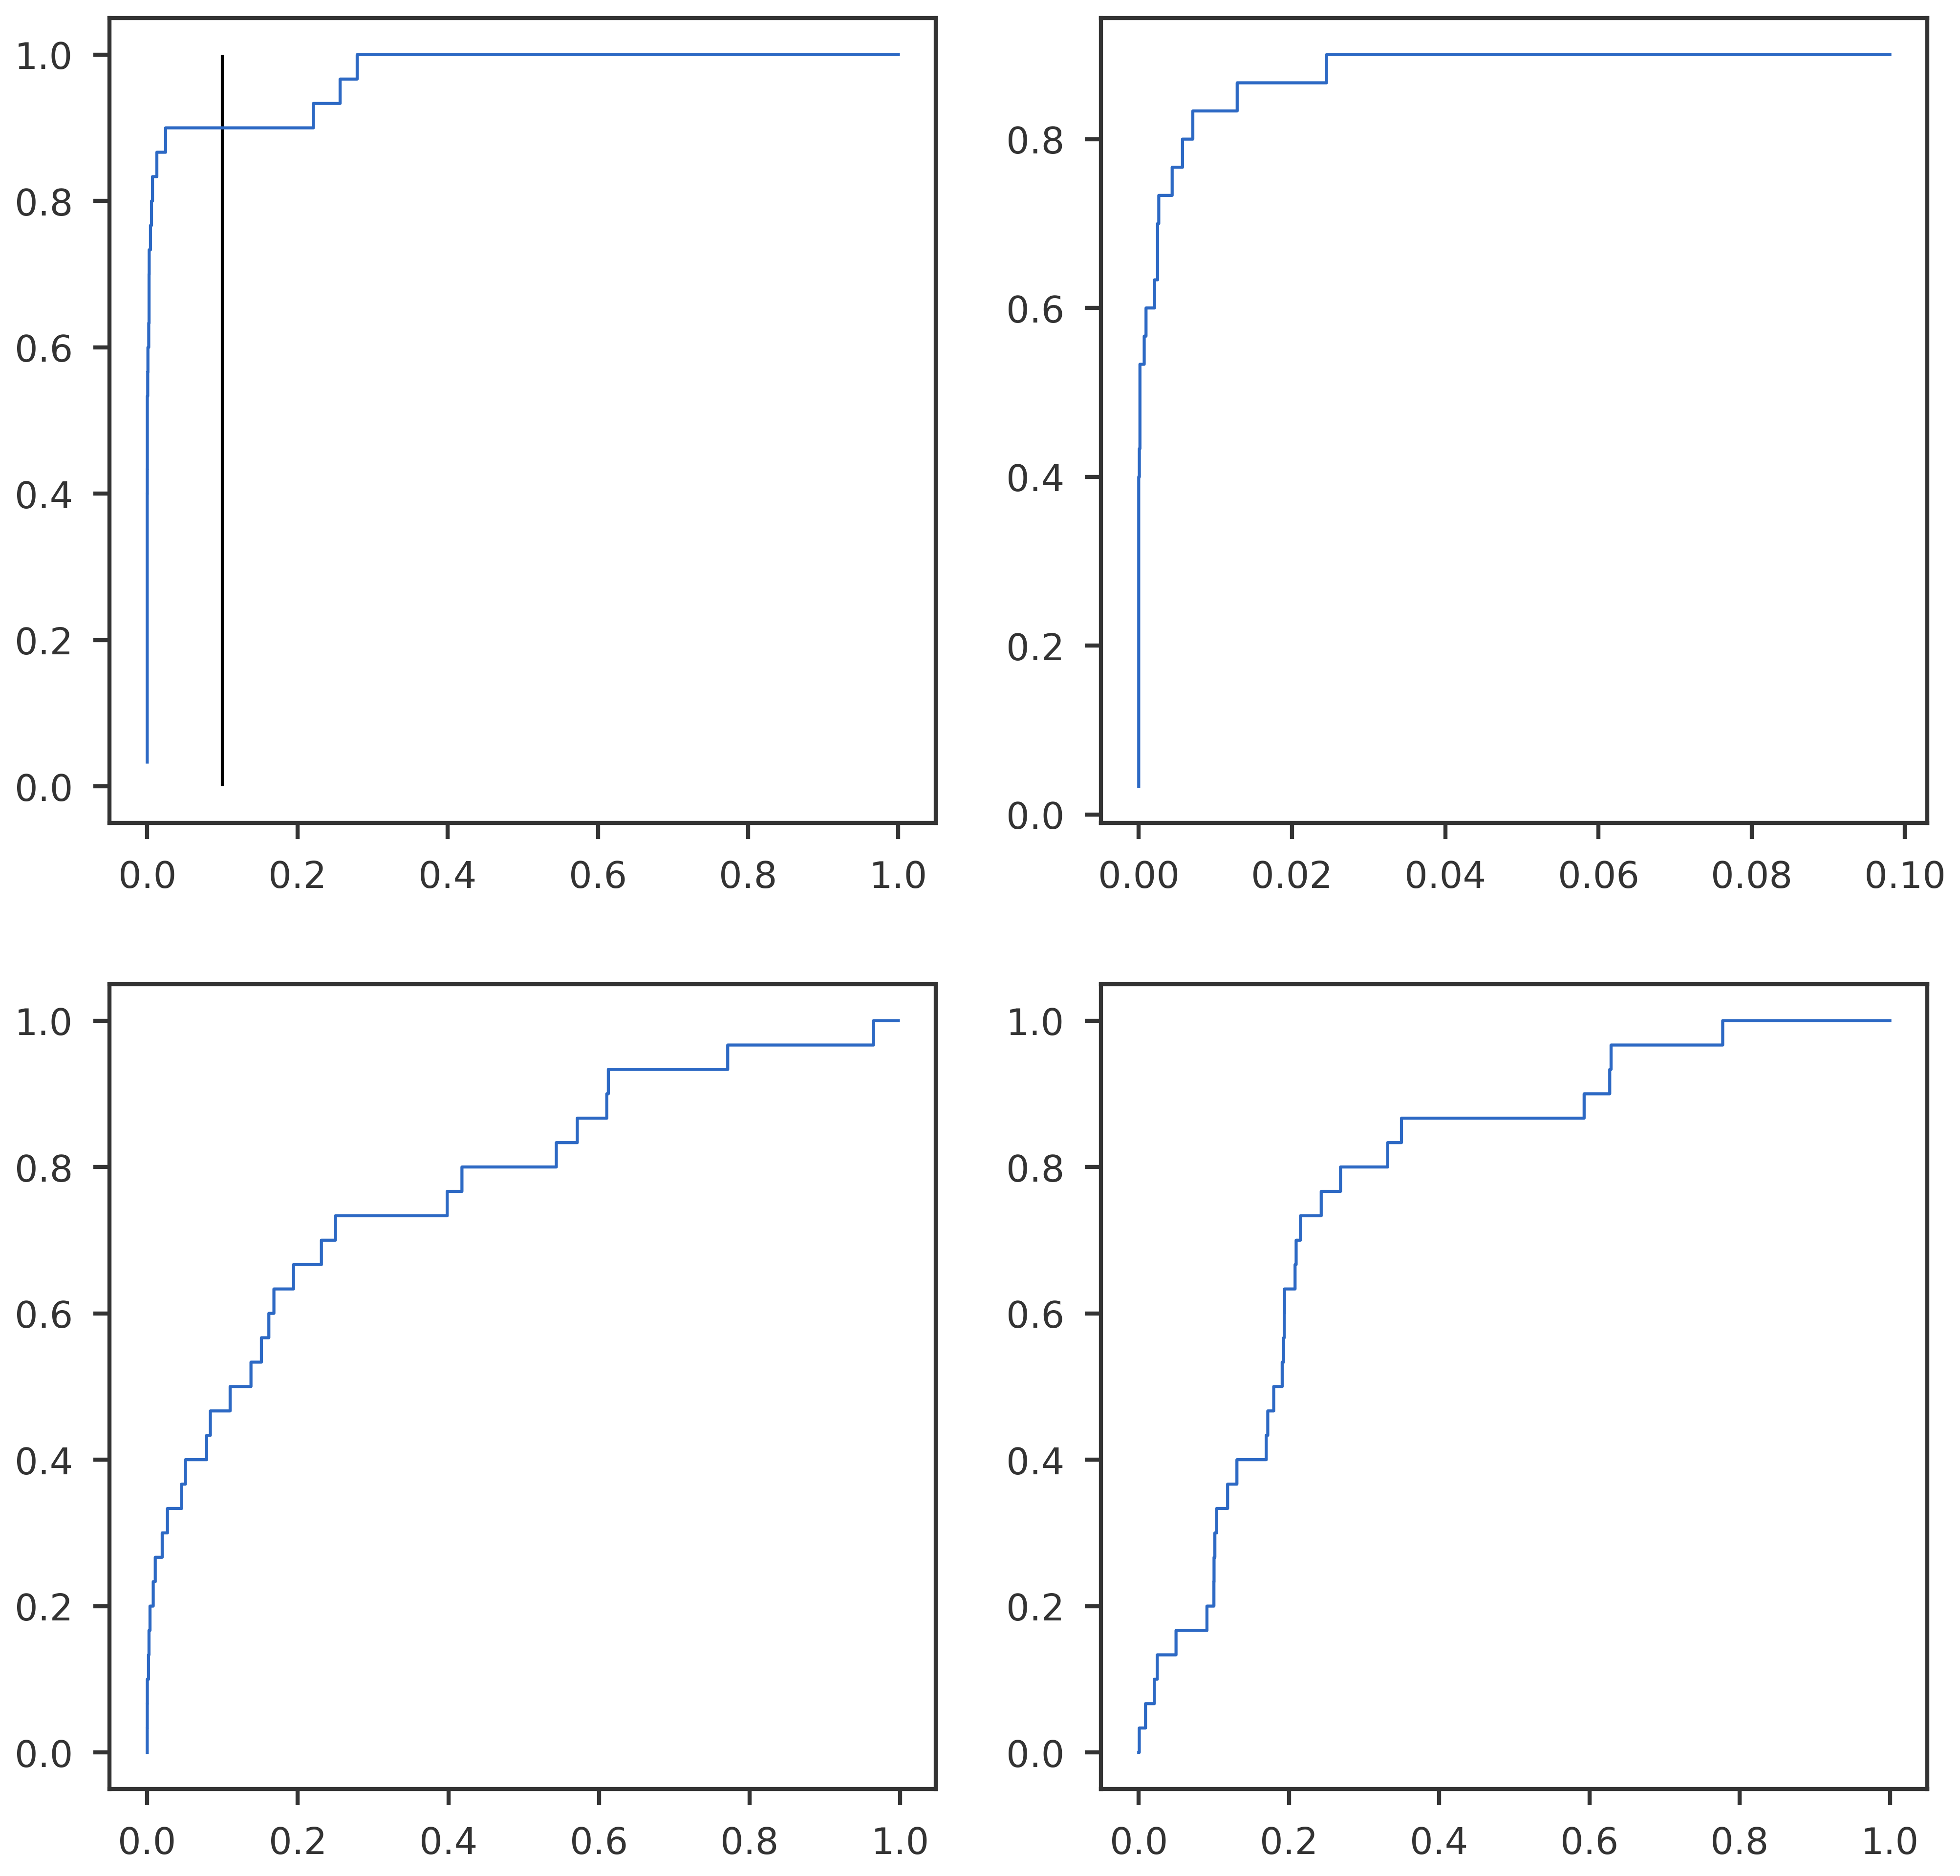

In [118]:
#############
# Calculate RR AUC for trans-eQTL discovery
#############
import matplotlib.pyplot as plt
from numpy import trapz

fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


rr_dict = TranseQTLs_rr
meqtl_dict = TranseQTLs_meqtl
jpa_dict = TranseQTLs_jpa

tp, fp, tpr, fpr = calc_rr_auc(trans_dict, rr_dict)
ax1.plot(fpr, tpr)

ax2.plot(fpr[:int(len(fpr)/10)], tpr[:int(len(tpr)/10)])
ax1.vlines(0.1, 0, 1)
auc_rr = trapz(tpr, fpr)
auc01_rr = trapz(tpr[:int(len(tpr)/10)], fpr[:int(len(fpr)/10)])

tp, fp, tpr, fpr = calc_meqtl_auc(trans_dict, meqtl_dict)
ax3.plot(fpr, tpr)
auc_meqtl = trapz(tpr, fpr)
auc01_meqtl = trapz(tpr[:int(len(tpr)/10)], fpr[:int(len(fpr)/10)])
    
tp, fp, tpr, fpr = calc_rr_auc(trans_dict, jpa_dict)
ax4.plot(fpr, tpr)
auc_jpa = trapz(tpr, fpr)
auc01_jpa = trapz(tpr[:int(len(tpr)/10)], fpr[:int(len(fpr)/10)])  
    
# tpr_sk = list()
# fpr_sk = list()
# with open(os.path.join(basedir, "rocdata/tejaas_permnull_sb0.1_raw_knn30_peer0_fpr_tpr.txt")) as inst:
#     next(inst)
#     for line in inst:
#         arr = line.rstrip().split()
#         fpr_sk.append(float(arr[0]))
#         tpr_sk.append(float(arr[1]))

# ax1.plot(fpr_sk, tpr_sk, linestyle="dashed", color="red")
# ax2.plot(fpr_sk[:int(len(fpr_sk)/10)], tpr_sk[:int(len(tpr_sk)/10)], linestyle="dashed", color="red")
plt.show()


In [100]:
# Interpolation as done by Saikat over multiple simulations
xmax = int(np.max([max(x) for x in all_fpr_list]) + 0.5)
ninterp = int(2 * np.max([len(x) for x in all_fpr_list]))
xvals = np.linspace(0, xmax, ninterp)
yest_arr = np.array([np.interp(xvals, all_fpr_list[i], all_tpr_list[i]) for i in range(20)])
yest = np.mean(yest_arr, axis = 0)

# AUC as by saikat
idx = np.where(xvals <= 0.1)[0]
auc_sk = integrate.simps(yest[idx], xvals[idx])
print(auc_sk)

tpr_sk = list()
fpr_sk = list()
with open(os.path.join(basedir, "rocdata/tejaas_permnull_sb0.1_raw_knn30_peer0_fpr_tpr.txt")) as inst:
    next(inst)
    for line in inst:
        arr = line.rstrip().split()
        fpr_sk.append(float(arr[0]))
        tpr_sk.append(float(arr[1]))

plt.plot(fpr_sk, tpr_sk)
plt.plot(xvals, yest)
plt.show()

NameError: name 'all_fpr_list' is not defined

0.9725354905226425 0.7766410844739826 0.7800962275623231


[]

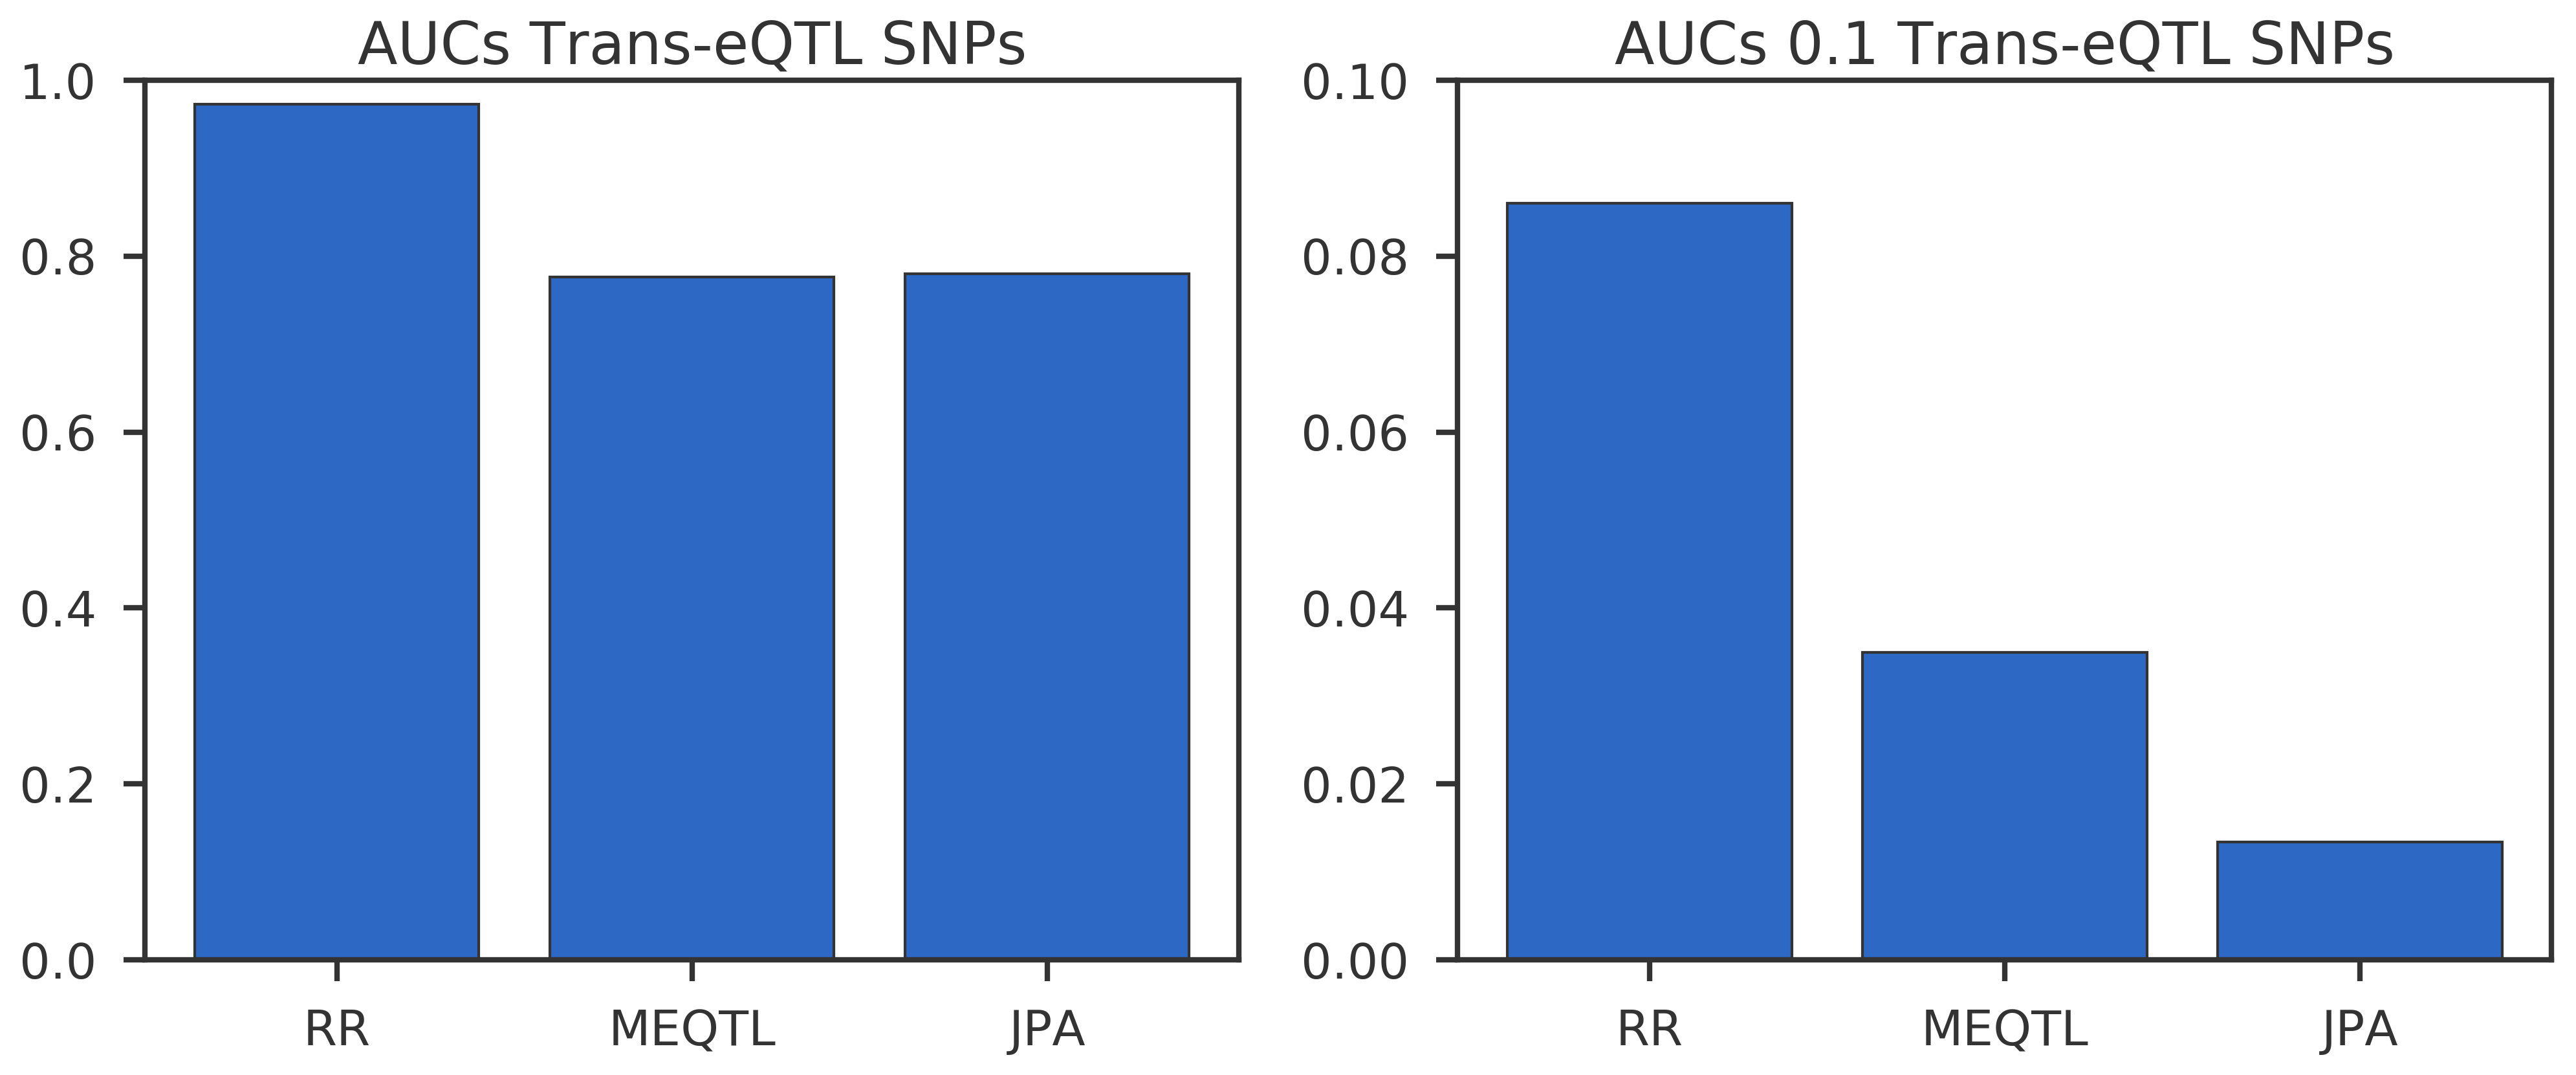

In [120]:
print(auc_rr, auc_meqtl, auc_jpa)

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.bar([0,1,2], [auc_rr, auc_meqtl, auc_jpa], tick_label=["RR", "MEQTL", "JPA"])
ax1.set_title("AUCs Trans-eQTL SNPs")
ax1.set_ylim(0,1)

ax2.set_title("AUCs 0.1 Trans-eQTL SNPs")
ax2.bar([0,1,2], [auc01_rr, auc01_meqtl, auc01_jpa], tick_label=["RR", "MEQTL", "JPA"])
ax2.set_ylim(0, 0.1)

plt.plot()

# Trans-eQTL discovery with FDR
### Can't be done apparently since null model changes for each SNP

In [10]:
############################
# Trans-eQTL discovery at X% FDR
# This will not work for Tejaas.. not possible to do FDR
# WHY? null work for each snp, but now for all snps as a whole?
############################
# FDR for trans-target gene discovery
############################

def bh_procedure(sorted_snp_pval, target_fdr):
    n_tests = len(sorted_snp_pval) # equivalent to ntrans-eqtls * ngenes
    pass_snps = list()
    for i, snp_pval in enumerate(sorted_snp_pval):
        bh_factor = ((i+1)/n_tests)*target_fdr
        if snp_pval[1] <= bh_factor:
            pass_snps.append(snp_pval)
        else:
            break
    return pass_snps

def bonferroni(sorted_snp_pval, target_fdr):
    n_tests = len(sorted_snp_pval)
    pass_snps = list()
    bf_cut = target_fdr/n_tests
    for snp_pval in sorted_snp_pval:
        if snp_pval[1] <= bf_cut:
            pass_snps.append(snp_pval)
        else:
            break
    return pass_snps

target_fdr = 0.1
rr_dict = TranseQTLs_rr
meqtl_dict = TranseQTLs_meqtl
jpa_dict = TranseQTLs_jpa

sorted_snp_rr = sorted([(snp, rr_dict[snp]["pval"]) for snp in rr_dict], key=lambda item: item[1])
sorted_snp_meqtl = sorted([(snp, meqtl_dict[snp]["fdr"]) for snp in meqtl_dict], key=lambda item: item[1])
sorted_snp_jpa = sorted([(snp, jpa_dict[snp]["pval"]) for snp in jpa_dict], key=lambda item: item[1])


### BH procedure
rr_bh_pass_snps = bh_procedure(sorted_snp_rr, target_fdr)

jpa_bh_pass_snps = bh_procedure(sorted_snp_jpa, target_fdr)


### Bonferroni procedure
rr_bf_pass_snps = bonferroni(sorted_snp_rr, target_fdr)

meqtl_pass_snps = [x for x in sorted_snp_meqtl if x[1] <= target_fdr]

meqtl_tp = [x for x in meqtl_pass_snps if x[0] in trans_dict]
rr_tp = [x for x in rr_bh_pass_snps if x[0] in trans_dict]
jpa_tp = [x for x in jpa_bh_pass_snps if x[0] in trans_dict]
print( "meqtl:\t", len(meqtl_tp), len(meqtl_pass_snps))
print( "rr:\t", len(rr_tp), len(rr_bh_pass_snps))
print( "jpa:\t", len(jpa_tp), len(jpa_bh_pass_snps))



meqtl:	 0 0
rr:	 0 0
jpa:	 12 1832


# Target - Gene discovery Section

### AUC of target genes for each simulated trans-eQTL

100 12539 12639 0.7533238389113063 0.000128942
100 12539 12639 0.9360598148587703 0.000211626
100 12539 12639 0.9450399556926973 3.80823e-05
100 12539 12639 0.9539591739852836 6.02697e-05
100 12539 12639 0.7765503599968351 0.0908547
100 12539 12639 0.8945185536830446 0.000413348
100 12539 12639 0.8588100324392752 0.00428057
100 12539 12639 0.9684563652187672 3.25079e-05
100 12539 12639 0.86069942242266 0.00504933
100 12539 12639 0.8841229527652503 0.00075284
100 12539 12639 0.8913577023498696 0.00792694
100 12539 12639 0.90142574570773 9.73937e-05
100 12539 12639 0.8535453754252709 0.00367526
100 12539 12639 0.8830856871587941 6.74984e-05
100 12539 12639 0.8937993512144948 0.00152122
100 12539 12639 0.8660329139963605 0.0023788
100 12539 12639 0.9583859482553999 0.000605523
100 12539 12639 0.9630777751404382 4.26941e-05
100 12539 12639 0.8208893108632012 0.0135657
100 12539 12639 0.9558580583906954 0.000615804
100 12539 12639 0.9622565076350977 0.000221186
100 12539 12639 0.58941292823

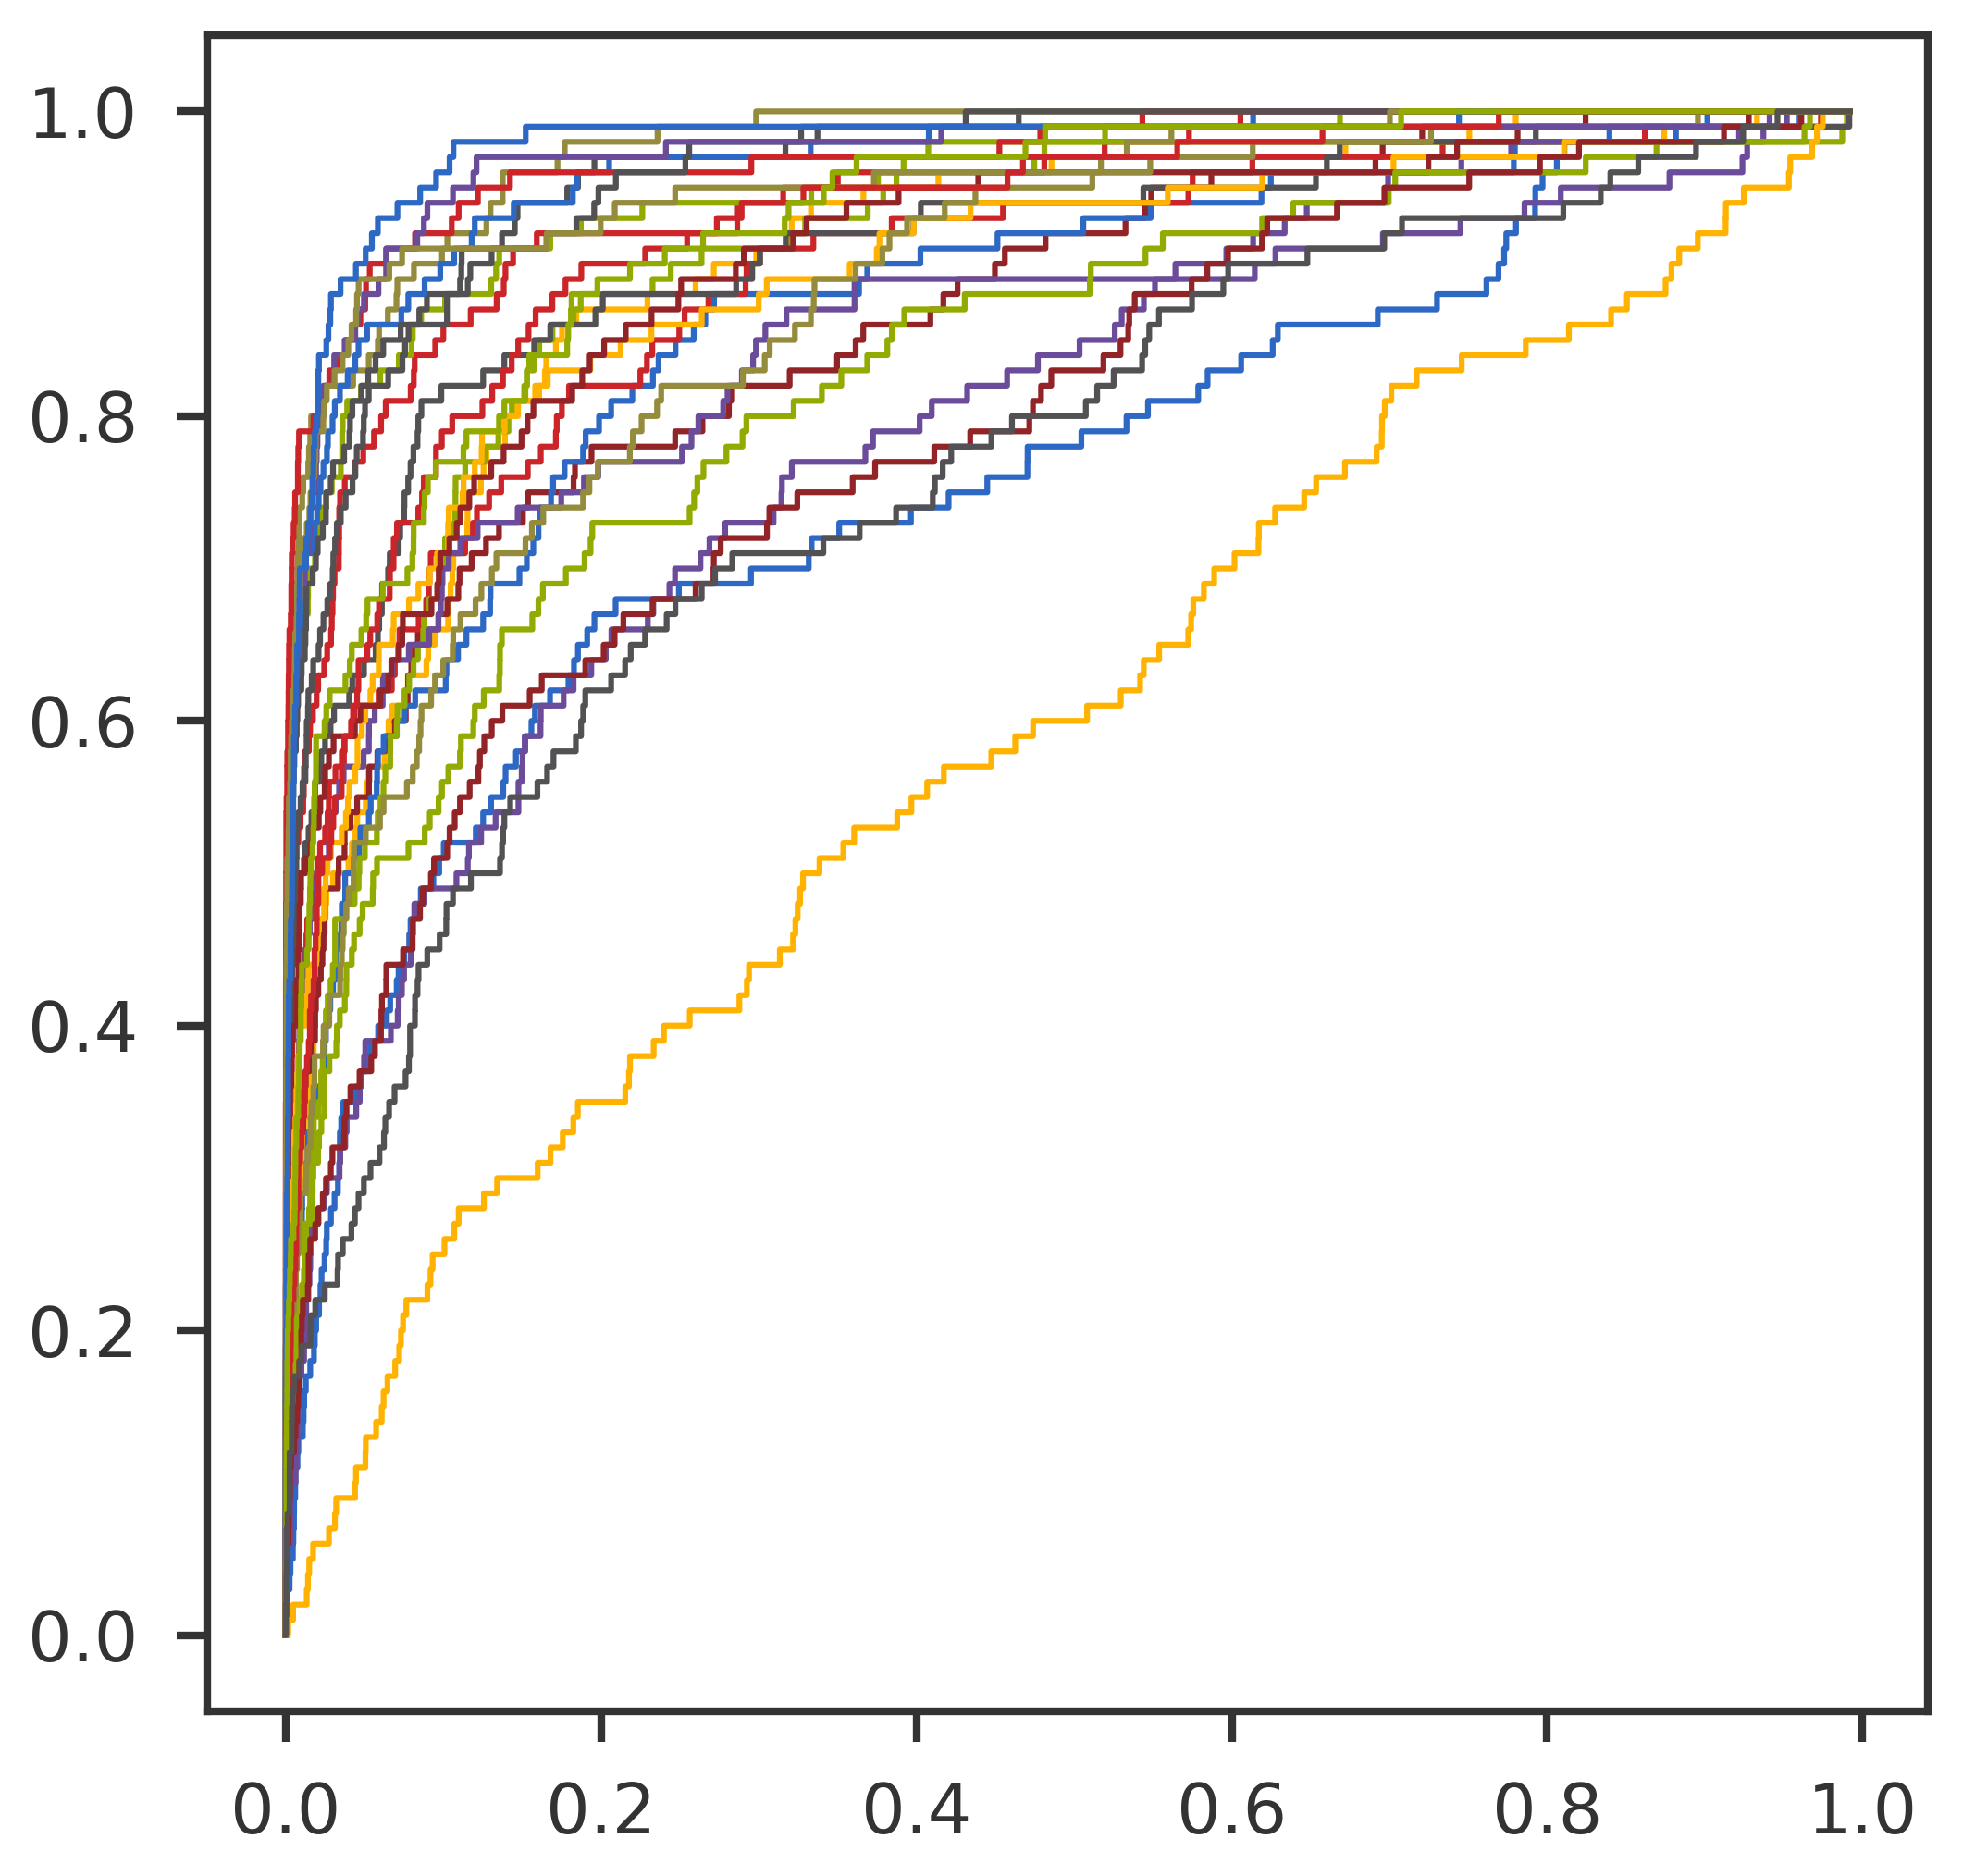

Tejaas found 28/30
If not all trans-eQTL were found it's because Tejaas calculates gene pvalues 
only for those that pass a pval thres first
Those trans-eQTLs might have a high pval :(


In [140]:
########################
# Target genes discovery AUCs
########################

target_genes = TargetedGenes_rr #["cclm"]

found = 0
foundsnplist = list()
auc_snp_pval = list()
for snp in target_genes:
    if snp in trans_dict:
        found += 1
#         print(f"found {snp}")
        foundsnplist.append(snp)
        sorted_list = [k for k, v in sorted(target_genes[snp].items(), key=lambda item: item[1])]
        tp = 0
        fp = 0
        tpr = list()
        fpr = list()
        for i,gene in enumerate(sorted_list):
            if gene in trans_dict[snp]['targets']:
                tp += 1
            else:
                fp += 1
            tpr.append(tp)
            fpr.append(fp)
        tpr = np.array(tpr)/len(trans_dict[snp]['targets'])
        fpr = np.array(fpr)/len(target_genes[snp].keys())
        auc = np.trapz(tpr, fpr)
        print(tp, fp, tp+fp, auc, rr_dict[snp]['pval'])
        auc_snp_pval.append((auc, rr_dict[snp]['pval']))
        plt.plot(fpr, tpr)
plt.show()
print(f"Tejaas found {found}/{len(trans_dict.keys())}")
print("If not all trans-eQTL were found it's because Tejaas calculates gene pvalues \nonly for those that pass a pval thres first")
print("Those trans-eQTLs might have a high pval :(")


In [1]:
target_genes = TargetedGenes_jpa

found = 0
foundsnplist = list()
auc_snp_pval = list()
for snp in target_genes:
    if snp in trans_dict:
        found += 1
#         print(f"found {snp}")
        foundsnplist.append(snp)
        sorted_list = [k for k, v in sorted(target_genes[snp].items(), key=lambda item: item[1])]
        tp = 0
        fp = 0
        tpr = list()
        fpr = list()
        for i,gene in enumerate(sorted_list):
            if gene in trans_dict[snp]['targets']:
                tp += 1
            else:
                fp += 1
            tpr.append(tp)
            fpr.append(fp)
        tpr = np.array(tpr)/len(trans_dict[snp]['targets'])
        fpr = np.array(fpr)/len(target_genes[snp].keys())
        auc = np.trapz(tpr, fpr)
        print(tp, fp, tp+fp, auc, jpa_dict[snp]['pval'])
        auc_snp_pval.append((auc, jpa_dict[snp]['pval']))
        plt.plot(fpr, tpr)
plt.show()


NameError: name 'TargetedGenes_jpa' is not defined

28


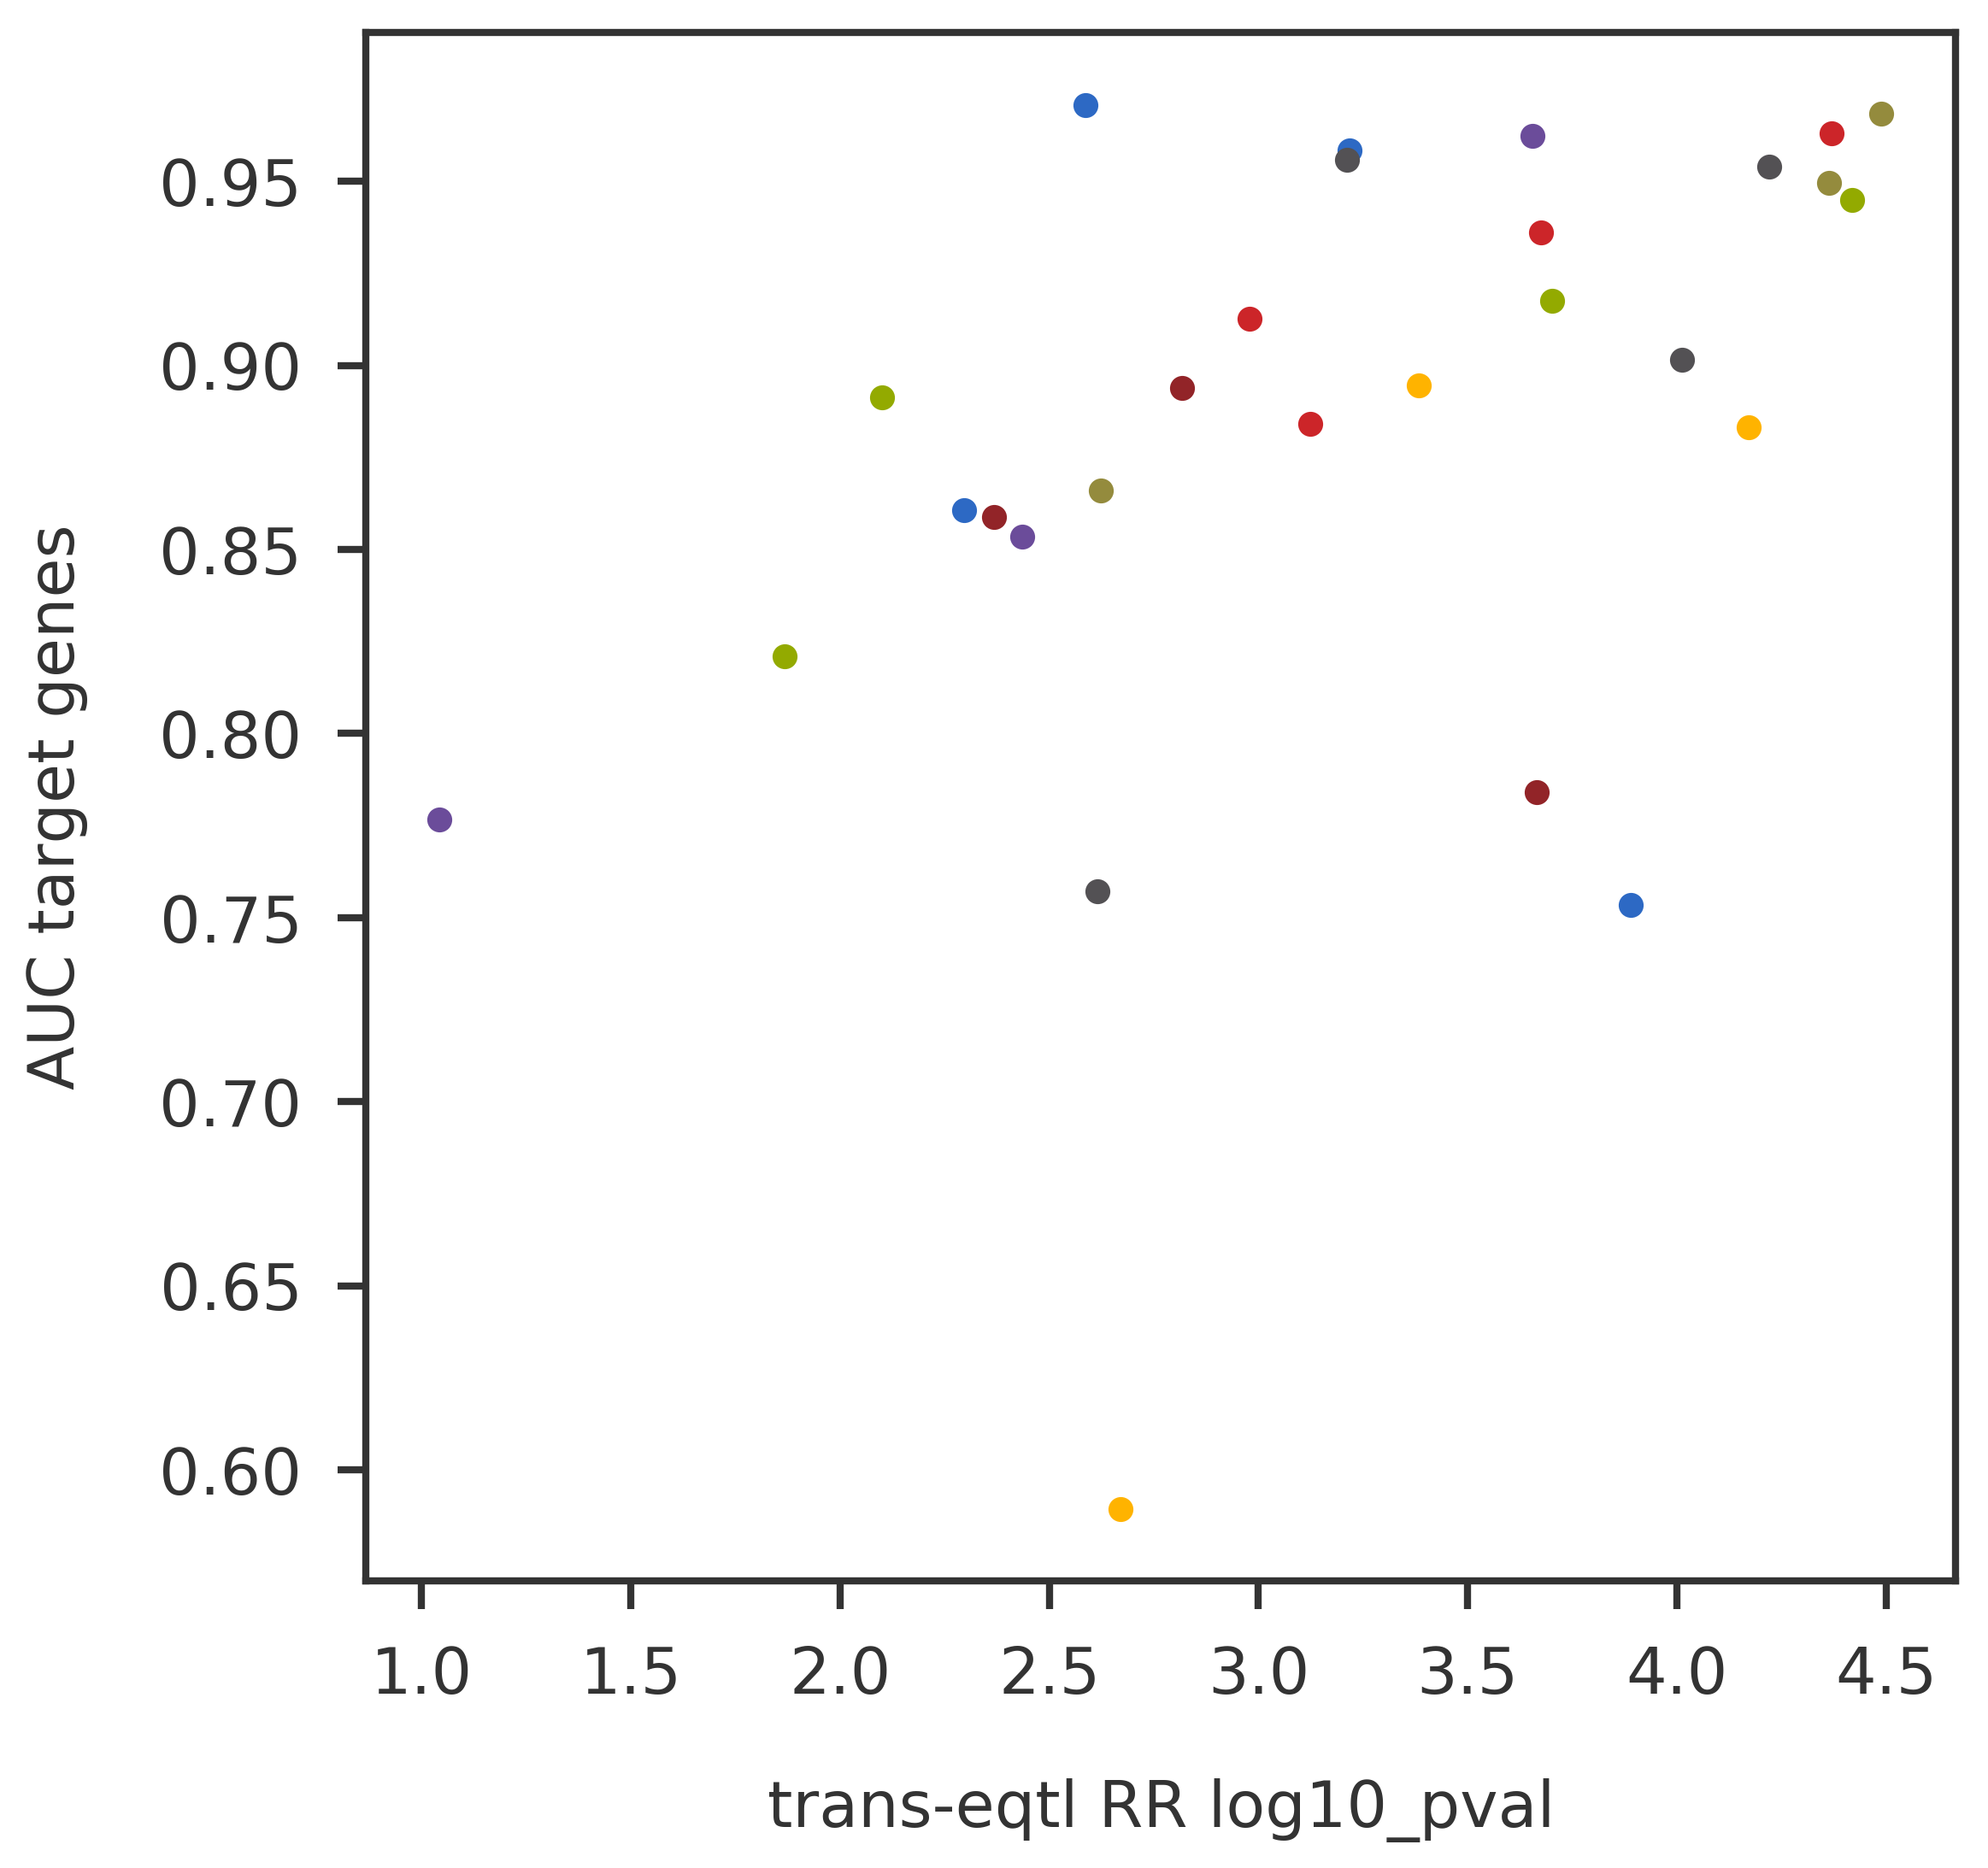

In [143]:
print(len(auc_snp_pval))
for auc, pval in auc_snp_pval:
    plt.scatter(-np.log10(pval), auc)
    plt.ylabel("AUC target genes")
    plt.xlabel("trans-eqtl RR log10_pval")
#     plt.scatter(pval, auc)
plt.show()

# Target-gene discovery with trans-eQTL snp cutoffs
### This considers even false positive trans-eQTLs

In [147]:
########################
# Target genes discovery over ALL possible trans-eQTL up to a pvalue X
########################

SIM_FIELDS = ['simname', 'auc', 'auc01', 'auc001', 'cutoff', 'tp', 'tn']
class SimResult(collections.namedtuple('SIMFIELDS', SIM_FIELDS)):
    __slots__ = ()

auc_res = list()
auc_abs_res = list()
snp_cutoffs = [0.01, 0.001, 0.0001]
ngenes   = 12639 #15064
ntargets = 100
ntrans = 30

rr_dict = TranseQTLs_rr
target_dict = TargetedGenes_rr #["cclm"]

## First, get an ordered list of all snp-gene-pvalues
snp_gene_pairs = [(snp, geneid, target_dict[snp][geneid]) for snp in target_dict for geneid in target_dict[snp]]
sorted_pairs = sorted(snp_gene_pairs, key=lambda item: item[2])

## then go through that list, but only consider snps where tejaas pval is lower than cutoff
for snp_cutoff in snp_cutoffs:
    pass_pairs = list()
    for snpid, geneid, pval in sorted_pairs:
        if rr_dict[snpid]['pval'] <= snp_cutoff:
            pass_pairs.append((snpid, geneid, pval))
            # print(snpid, geneid, pval, rr_dict[snpid]['pval'])

    print(len(pass_pairs))

    tp = 0
    fp = 0
    tpr = list()
    fpr = list()
    if len(pass_pairs) > 0:
        for snpid, geneid, pval in pass_pairs:
            if snpid in trans_dict:
                if geneid in trans_dict[snpid]['targets']:
                    tp += 1
                else:
                    fp += 1
            else:
                fp += 1
            tpr.append(tp)
            fpr.append(fp)

        print(simname, snp_cutoff, tp, fp)
        tpr_rel = np.array(tpr)/tpr[-1]
        fpr_rel = np.array(fpr)/fpr[-1]
        # tpr_abs = np.array(tpr)/(ntrans*ntargets)
        # fpr_abs = np.array(fpr)/((ngenes-ntargets)*ngenes)

        auc = trapz(tpr_rel, fpr_rel)
        auc01 = trapz(tpr_rel[:int(len(tpr_rel)/10)], fpr_rel[:int(len(fpr_rel)/10)])
        auc001 = trapz(tpr_rel[:int(len(tpr_rel)/100)], fpr_rel[:int(len(fpr_rel)/100)])

        # auc_abs = trapz(tpr_abs, fpr_abs)
        # auc01_abs = trapz(tpr_abs[:int(len(tpr_abs)/10)], fpr_abs[:int(len(fpr_abs)/10)])
        # auc001_abs = trapz(tpr_abs[:int(len(tpr_abs)/100)], fpr_abs[:int(len(fpr_abs)/100)])

        res = SimResult(simname=simname, auc=auc, auc01=auc01, auc001=auc001, cutoff=snp_cutoff, tp=tp, tn=fp)
        # res_abs = SimResult(simname=simname, auc=auc_abs, auc01=auc01_abs, auc001=auc001_abs, cutoff=snp_cutoff, tp=tp, tn=fp)
    else:
        res = SimResult(simname=simname, auc=0, auc01=0, auc001=0, cutoff=snp_cutoff, tp=0, tn=0)
        # res_abs = SimResult(simname=simname, auc=0, auc01=0, auc001=0, cutoff=snp_cutoff, tp=0, tn=0)
    auc_res.append(res)
    # auc_abs_res.append(res_abs)

2906970
sim001 0.01 2600 2904370
290697
sim001 0.001 1600 289097
88473
sim001 0.0001 700 87773


In [11]:
########################
# rework on BH procedure
########################

rr_dict = TranseQTLs_rr
target_dict = TargetedGenes_rr

## First, get an ordered list of all snp-gene-pvalues
snp_gene_pairs = [(snp, geneid, target_dict[snp][geneid]) for snp in target_dict for geneid in target_dict[snp]]
sorted_pairs = sorted(snp_gene_pairs, key=lambda item: item[2])

snp_cutoff = 0.0001
pass_pairs = list()
for snpid, geneid, pval in sorted_pairs:
    if rr_dict[snpid]['pval'] <= snp_cutoff:
        pass_pairs.append((snpid, geneid, pval))
        
print(len(pass_pairs), len(snp_gene_pairs), len(pass_pairs)/len(snp_gene_pairs))

88473 38713250 0.002285341582016493


In [54]:
#######################################
# BH procedure over all snp-gene pairs together
#######################################

sorted_snp_gene_pval = pass_pairs
target_fdr=0.1
n_tests = len(sorted_snp_gene_pval) # equivalent to ntrans-eqtls * ngenes
pass_snps = list()
bh_index_limit = -1
for i, snp_pval in enumerate(sorted_snp_gene_pval[::-1]):
    bh_factor = ((n_tests-i)/n_tests)*target_fdr
    if snp_pval[2] > bh_factor:
        # pass_snps.append(snp_pval)
        continue
    else:
        bh_index_limit = n_tests-i-1
        break
pass_fdr = [sorted_snp_gene_pval[i] for i in range(bh_index_limit)]
adj_pvals = [sorted_snp_gene_pval[i][2]*(n_tests/(i+1)) for i in range(n_tests)]
        
print(bh_index_limit)
print("Reached pval", pass_pairs[bh_index_limit])
print("target BH limit", ((bh_index_limit)/n_tests)*target_fdr)

# 106
# Reached pval ('rs185240114', 'ENSG001928', 2.90476e-07)
# target BH limit 2.7380806313084023e-07

150
Reached pval ('rs6502892', 'ENSG009227', 0.000168552)
target BH limit 0.00016954325048319828


In [55]:
lim = 200
counter = 0
for i,x in enumerate(pass_pairs):
    print(i,x, adj_pvals[i])
    counter += 1
    if counter > lim:
        break

0 ('rs113721499', 'ENSG004520', 1.11022e-16) 9.822449406e-12
1 ('rs12302233', 'ENSG008570', 1.11022e-16) 4.911224703e-12
2 ('rs6502892', 'ENSG010678', 1.64868e-13) 4.862122188e-09
3 ('rs4532197', 'ENSG002960', 3.35731e-13) 7.42578219075e-09
4 ('rs80126140', 'ENSG002406', 9.86544e-13) 1.74565014624e-08
5 ('rs113721499', 'ENSG005204', 2.97062e-12) 4.380327721e-08
6 ('rs10961474', 'ENSG006586', 6.15625e-11) 7.780884375e-07
7 ('rs181647', 'ENSG007576', 1.41255e-09) 1.5621567018750002e-05
8 ('rs12302233', 'ENSG002817', 8.06892e-09) 7.932017324e-05
9 ('rs113721499', 'ENSG002704', 3.06599e-08) 0.00027125733327
10 ('rs80126140', 'ENSG007833', 9.28812e-08) 0.0007470434915999999
11 ('rs4532197', 'ENSG011541', 1.68088e-07) 0.0012392708019999998
12 ('rs113721499', 'ENSG011748', 6.04087e-07) 0.004111183780846154
13 ('rs6502892', 'ENSG007313', 8.78104e-07) 0.005549178228
14 ('rs113721499', 'ENSG010537', 1.04962e-06) 0.006190868683999999
15 ('rs12302233', 'ENSG000499', 1.06254e-06) 0.00587538133875
1

In [ ]:
#######################################
# BH procedure over snp-gene for every trans-eQTL separately
#######################################

################### TODO, change everything
rr_dict = TranseQTLs_rr
target_dict = TargetedGenes_rr

## First, get an ordered list of all snp-gene-pvalues
snp_gene_pairs = [(snp, geneid, target_dict[snp][geneid]) for snp in target_dict for geneid in target_dict[snp]]
sorted_pairs = sorted(snp_gene_pairs, key=lambda item: item[2])

snp_cutoff = 0.0001
pass_pairs = list()
for snpid, geneid, pval in sorted_pairs:
    if rr_dict[snpid]['pval'] <= snp_cutoff:
        pass_pairs.append((snpid, geneid, pval))
        
print(len(pass_pairs), len(snp_gene_pairs), len(pass_pairs)/len(snp_gene_pairs))

#######################################

sorted_snp_gene_pval = pass_pairs
target_fdr=0.1
n_tests = len(sorted_snp_gene_pval) # equivalent to ntrans-eqtls * ngenes
pass_snps = list()
bh_index_limit = -1
for i, snp_pval in enumerate(sorted_snp_gene_pval[::-1]):
    bh_factor = ((n_tests-i)/n_tests)*target_fdr
    if snp_pval[2] > bh_factor:
        # pass_snps.append(snp_pval)
        continue
    else:
        bh_index_limit = n_tests-i-1
        break
pass_fdr = [sorted_snp_gene_pval[i] for i in range(bh_index_limit)]
adj_pvals = [sorted_snp_gene_pval[i][2]*(n_tests/(i+1)) for i in range(n_tests)]
        
print(bh_index_limit)
print("Reached pval", pass_pairs[bh_index_limit])
print("target BH limit", ((bh_index_limit)/n_tests)*target_fdr)


In [165]:

auc_res_jpa = list()
snp_cutoffs = [0.01, 0.001, 0.0001]
ngenes   = 12639 #15064
ntargets = 100
ntrans = 30

jpa_dict = TranseQTLs_jpa
target_dict = TargetedGenes_jpa

## First, get an ordered list of all snp-gene-pvalues
snp_gene_pairs = [(snp, geneid, target_dict[snp][geneid]) for snp in target_dict for geneid in target_dict[snp]]
sorted_pairs = sorted(snp_gene_pairs, key=lambda item: item[2])

## then go through that list, but only consider snps where tejaas pval is lower than cutoff
for snp_cutoff in snp_cutoffs:
    pass_pairs = list()
    for snpid, geneid, pval in sorted_pairs:
        if jpa_dict[snpid]['pval'] <= snp_cutoff:
            pass_pairs.append((snpid, geneid, pval))

    print(len(pass_pairs))

    tp = 0
    fp = 0
    tpr = list()
    fpr = list()
    if len(pass_pairs) > 0:
        for snpid, geneid, pval in pass_pairs:
            if snpid in trans_dict:
                if geneid in trans_dict[snpid]['targets']:
                    tp += 1
                else:
                    fp += 1
            else:
                fp += 1
            tpr.append(tp)
            fpr.append(fp)

        print(simname, snp_cutoff, tp, fp)
        tpr_rel = np.array(tpr)/tpr[-1]
        fpr_rel = np.array(fpr)/fpr[-1]

        auc = trapz(tpr_rel, fpr_rel)
        auc01 = trapz(tpr_rel[:int(len(tpr_rel)/10)], fpr_rel[:int(len(fpr_rel)/10)])
        auc001 = trapz(tpr_rel[:int(len(tpr_rel)/100)], fpr_rel[:int(len(fpr_rel)/100)])

        res = SimResult(simname=simname, auc=auc, auc01=auc01, auc001=auc001, cutoff=snp_cutoff, tp=tp, tn=fp)
    else:
        res = SimResult(simname=simname, auc=0, auc01=0, auc001=0, cutoff=snp_cutoff, tp=0, tn=0)
    auc_res_jpa.append(res)

22446864
sim001 0.01 1200 22445664
18503496
sim001 0.001 1000 18502496
15394302
sim001 0.0001 600 15393702


In [166]:
for a in auc_res:
    print(a)

for a in auc_res_jpa:
    print(a)

SimResult(simname='sim001', auc=0.888772550964978, auc01=0.057511601880561425, auc001=0.002921190773267127, cutoff=0.01, tp=2600, tn=2904370)
SimResult(simname='sim001', auc=0.9211980126912421, auc01=0.0639576703493983, auc001=0.0027156045375773532, cutoff=0.001, tp=1600, tn=289097)
SimResult(simname='sim001', auc=0.9454535644706882, auc01=0.069745007820498, auc001=0.002514098868672599, cutoff=0.0001, tp=700, tn=87773)
SimResult(simname='sim001', auc=0.7723471689973967, auc01=0.03536733178547682, auc001=0.001301310652545929, cutoff=0.01, tp=1200, tn=22445664)
SimResult(simname='sim001', auc=0.7730284611330316, auc01=0.036038661162256166, auc001=0.0013256904906235353, cutoff=0.001, tp=1000, tn=18502496)
SimResult(simname='sim001', auc=0.7805505450648994, auc01=0.03648793545568182, auc001=0.0014264420172180373, cutoff=0.0001, tp=600, tn=15393702)


In [148]:
def bh_procedure_targetgenes(sorted_snp_gene_pval, target_fdr):
    n_tests = len(sorted_snp_gene_pval)
    pass_snps = list()
    for i, snp_pval in enumerate(sorted_snp_gene_pval):
        bh_factor = ((i+1)/n_tests)*target_fdr
        fdr_val = snp_pval[2] / bh_factor
        if snp_pval[2] <= bh_factor:
            pass_snps.append(snp_pval+(fdr_val,))
        else:
            break
    return pass_snps

target_fdr = 0.99
rr_dict = TranseQTLs_rr
target_dict = TargetedGenes_rr 

## First, get an ordered list of all snp-gene-pvalues
snp_gene_pairs = [(snp, geneid, target_dict[snp][geneid]) for snp in target_dict for geneid in target_dict[snp]]
sorted_pairs = sorted(snp_gene_pairs, key=lambda item: item[2])

pass_rr_targets = bh_procedure_targetgenes(sorted_pairs, target_fdr)
print(len(pass_rr_targets))

10687


In [149]:
jpa_dict = TranseQTLs_jpa
target_dict = TargetedGenes_jpa

## First, get an ordered list of all snp-gene-pvalues
snp_gene_pairs = [(snp, geneid, target_dict[snp][geneid]) for snp in target_dict for geneid in target_dict[snp]]
sorted_pairs = sorted(snp_gene_pairs, key=lambda item: item[2])

pass_jpa_targets = bh_procedure_targetgenes(sorted_pairs, target_fdr)
print(len(pass_jpa_targets))

0


In [150]:
pass_rr_targets_checked = list()
for snp_gene_pval in pass_rr_targets:
    isTeqtl = 0
    isTG = 0
    if snp_gene_pval[0] in trans_dict:
        isTeqtl = 1
        if snp_gene_pval[1] in trans_dict[snp_gene_pval[0]]['targets']:
            isTG = 1
    pass_rr_targets_checked.append(snp_gene_pval + (isTeqtl, isTG))
    
pass_jpa_targets_checked = list()
for snp_gene_pval in pass_jpa_targets:
    isTeqtl = 0
    isTG = 0
    if snp_gene_pval[0] in trans_dict:
        isTeqtl = 1
        if snp_gene_pval[1] in trans_dict[snp_gene_pval[0]]['targets']:
            isTG = 1
    pass_jpa_targets_checked.append(snp_gene_pval + (isTeqtl, isTG))

0.5714937038645246


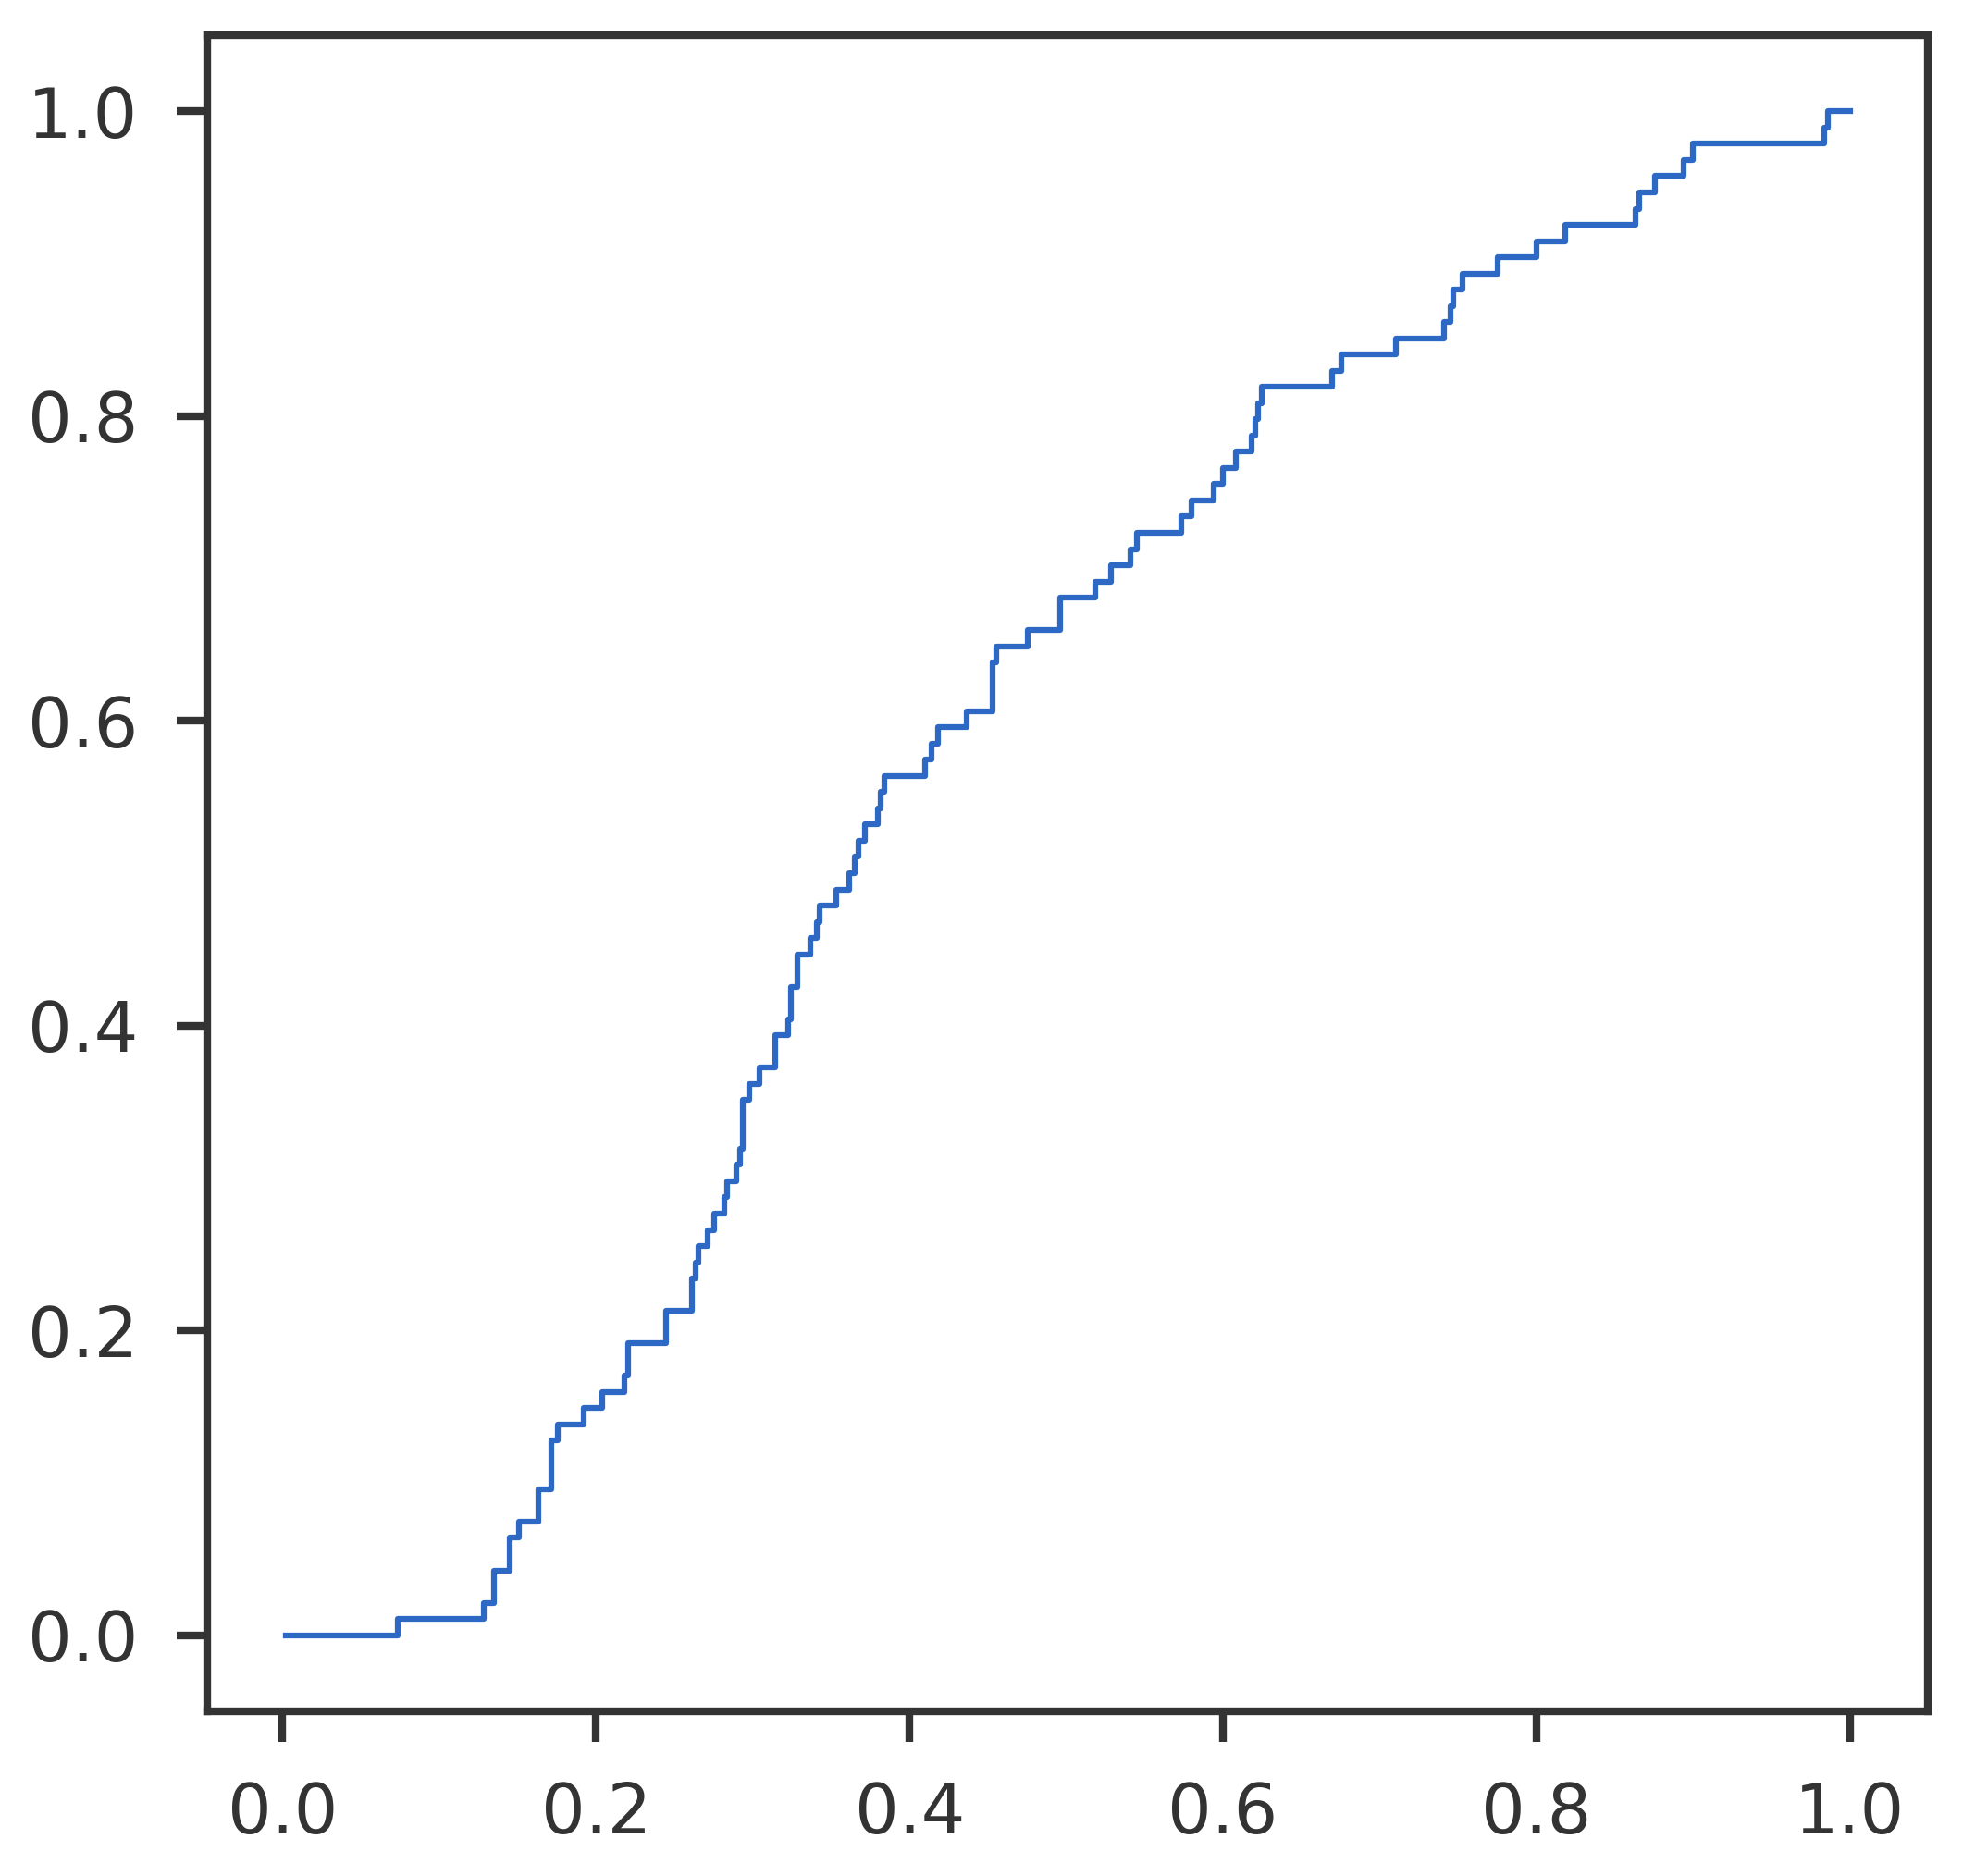

In [151]:
import matplotlib.pyplot as plt

tp = 0
fp = 0
tpr = list()
fpr = list()
for snp_gene_pval in pass_rr_targets:
    if snp_gene_pval[3] > 0.7:
        break
    if snp_gene_pval[0] in trans_dict:
        if snp_gene_pval[1] in trans_dict[snp_gene_pval[0]]['targets']:
            tp += 1
        else:
            fp += 1
    else:
        fp += 1
    tpr.append(tp)
    fpr.append(fp)
    
tpr = np.array(tpr)/tpr[-1]
fpr = np.array(fpr)/fpr[-1]

print(np.trapz(tpr, fpr))
plt.plot(fpr, tpr)
plt.show()


In [ ]:
TargetedGenes_meqtl["cclm"]

In [167]:
#######################
## AUC for matrixEQTL
#######################
auc_meqtl_res = list()


meqtl_dict = TranseQTLs_meqtl
target_dict = TargetedGenes_meqtl["cclm"]

## First, get an ordered list of all snp-gene-pvalues
snp_gene_pairs = [(snp, geneid, target_dict[snp][geneid]) for snp in target_dict for geneid in target_dict[snp]]
sorted_pairs = sorted(snp_gene_pairs, key=lambda item: item[2])

tp = 0
fp = 0
tpr = list()
fpr = list()
for snpid, geneid, pval in sorted_pairs:
    if snpid in trans_dict:
        if geneid in trans_dict[snpid]['targets']:
            tp += 1
        else:
            fp += 1
    else:
        fp += 1
    tpr.append(tp)
    fpr.append(fp)

print(simname, tp, fp)
tpr_rel = np.array(tpr)/tpr[-1]
fpr_rel = np.array(fpr)/fpr[-1]

auc = trapz(tpr_rel, fpr_rel)
auc01 = trapz(tpr_rel[:int(len(tpr_rel)/10)], fpr_rel[:int(len(fpr_rel)/10)])
auc001 = trapz(tpr_rel[:int(len(tpr_rel)/100)], fpr_rel[:int(len(fpr_rel)/100)])
res = SimResult(simname=simname, auc=auc, auc01=auc01, auc001=auc001, cutoff=0, tp=tp, tn=fp)
print(res)
auc_meqtl_res.append(res)

sim001 1439 15211570
SimResult(simname='sim001', auc=0.7496860913480348, auc01=0.03074945463120726, auc001=0.0010115065832563208, cutoff=0, tp=1439, tn=15211570)


In [105]:
roc_dir = os.path.join(basedir, "rocdata_franco_nocis")

sb = 0.2
all_meqtl = pd.DataFrame(np.array([]))
all_meqtl_tg = pd.DataFrame(np.array([]))
all_rr = pd.DataFrame(np.array([]))
all_rr_tg = pd.DataFrame(np.array([]))
for i in range(1,21):
    simname = "sim{:03d}".format(i)
    print(simname)
    ### trans-eQTL discovery
    meqtl_auc_file = os.path.join(roc_dir, f"meqtl_auc_{simname}.txt")
    rr_auc_file = os.path.join(roc_dir, f"rr_auc_{simname}_sb{sb}.txt")
    
    df_meqtl = pd.read_csv(meqtl_auc_file, header=0, sep="\t")
    if all_meqtl.shape[0] == 0:
        all_meqtl = df_meqtl
    else:
        all_meqtl = pd.concat([all_meqtl, df_meqtl])
        
    df_rr = pd.read_csv(rr_auc_file, header=0, sep="\t")
    if all_rr.shape[0] == 0:
        all_rr = df_rr
    else:
        all_rr = pd.concat([all_rr, df_rr])
   
    
    tg_meqtl_auc_file = os.path.join(roc_dir, f"meqtl_targetgene_auc_{simname}.txt")
    tg_rr_auc_file = os.path.join(roc_dir, f"rr_targetgene_auc_{simname}_sb{sb}.txt")
    
    df_meqtl_tg = pd.read_csv(tg_meqtl_auc_file, header=0, sep="\t")
    if all_meqtl_tg.shape[0] == 0:
        all_meqtl_tg = df_meqtl_tg
    else:
        all_meqtl_tg = pd.concat([all_meqtl_tg, df_meqtl_tg])
        
    df_rr_tg = pd.read_csv(tg_rr_auc_file, header=0, sep="\t")
    if all_rr_tg.shape[0] == 0:
        all_rr_tg = df_rr_tg
    else:
        all_rr_tg = pd.concat([all_rr_tg, df_rr_tg])
    

sim001
sim002
sim003
sim004
sim005
sim006
sim007
sim008
sim009
sim010
sim011
sim012
sim013
sim014
sim015
sim016
sim017
sim018
sim019
sim020


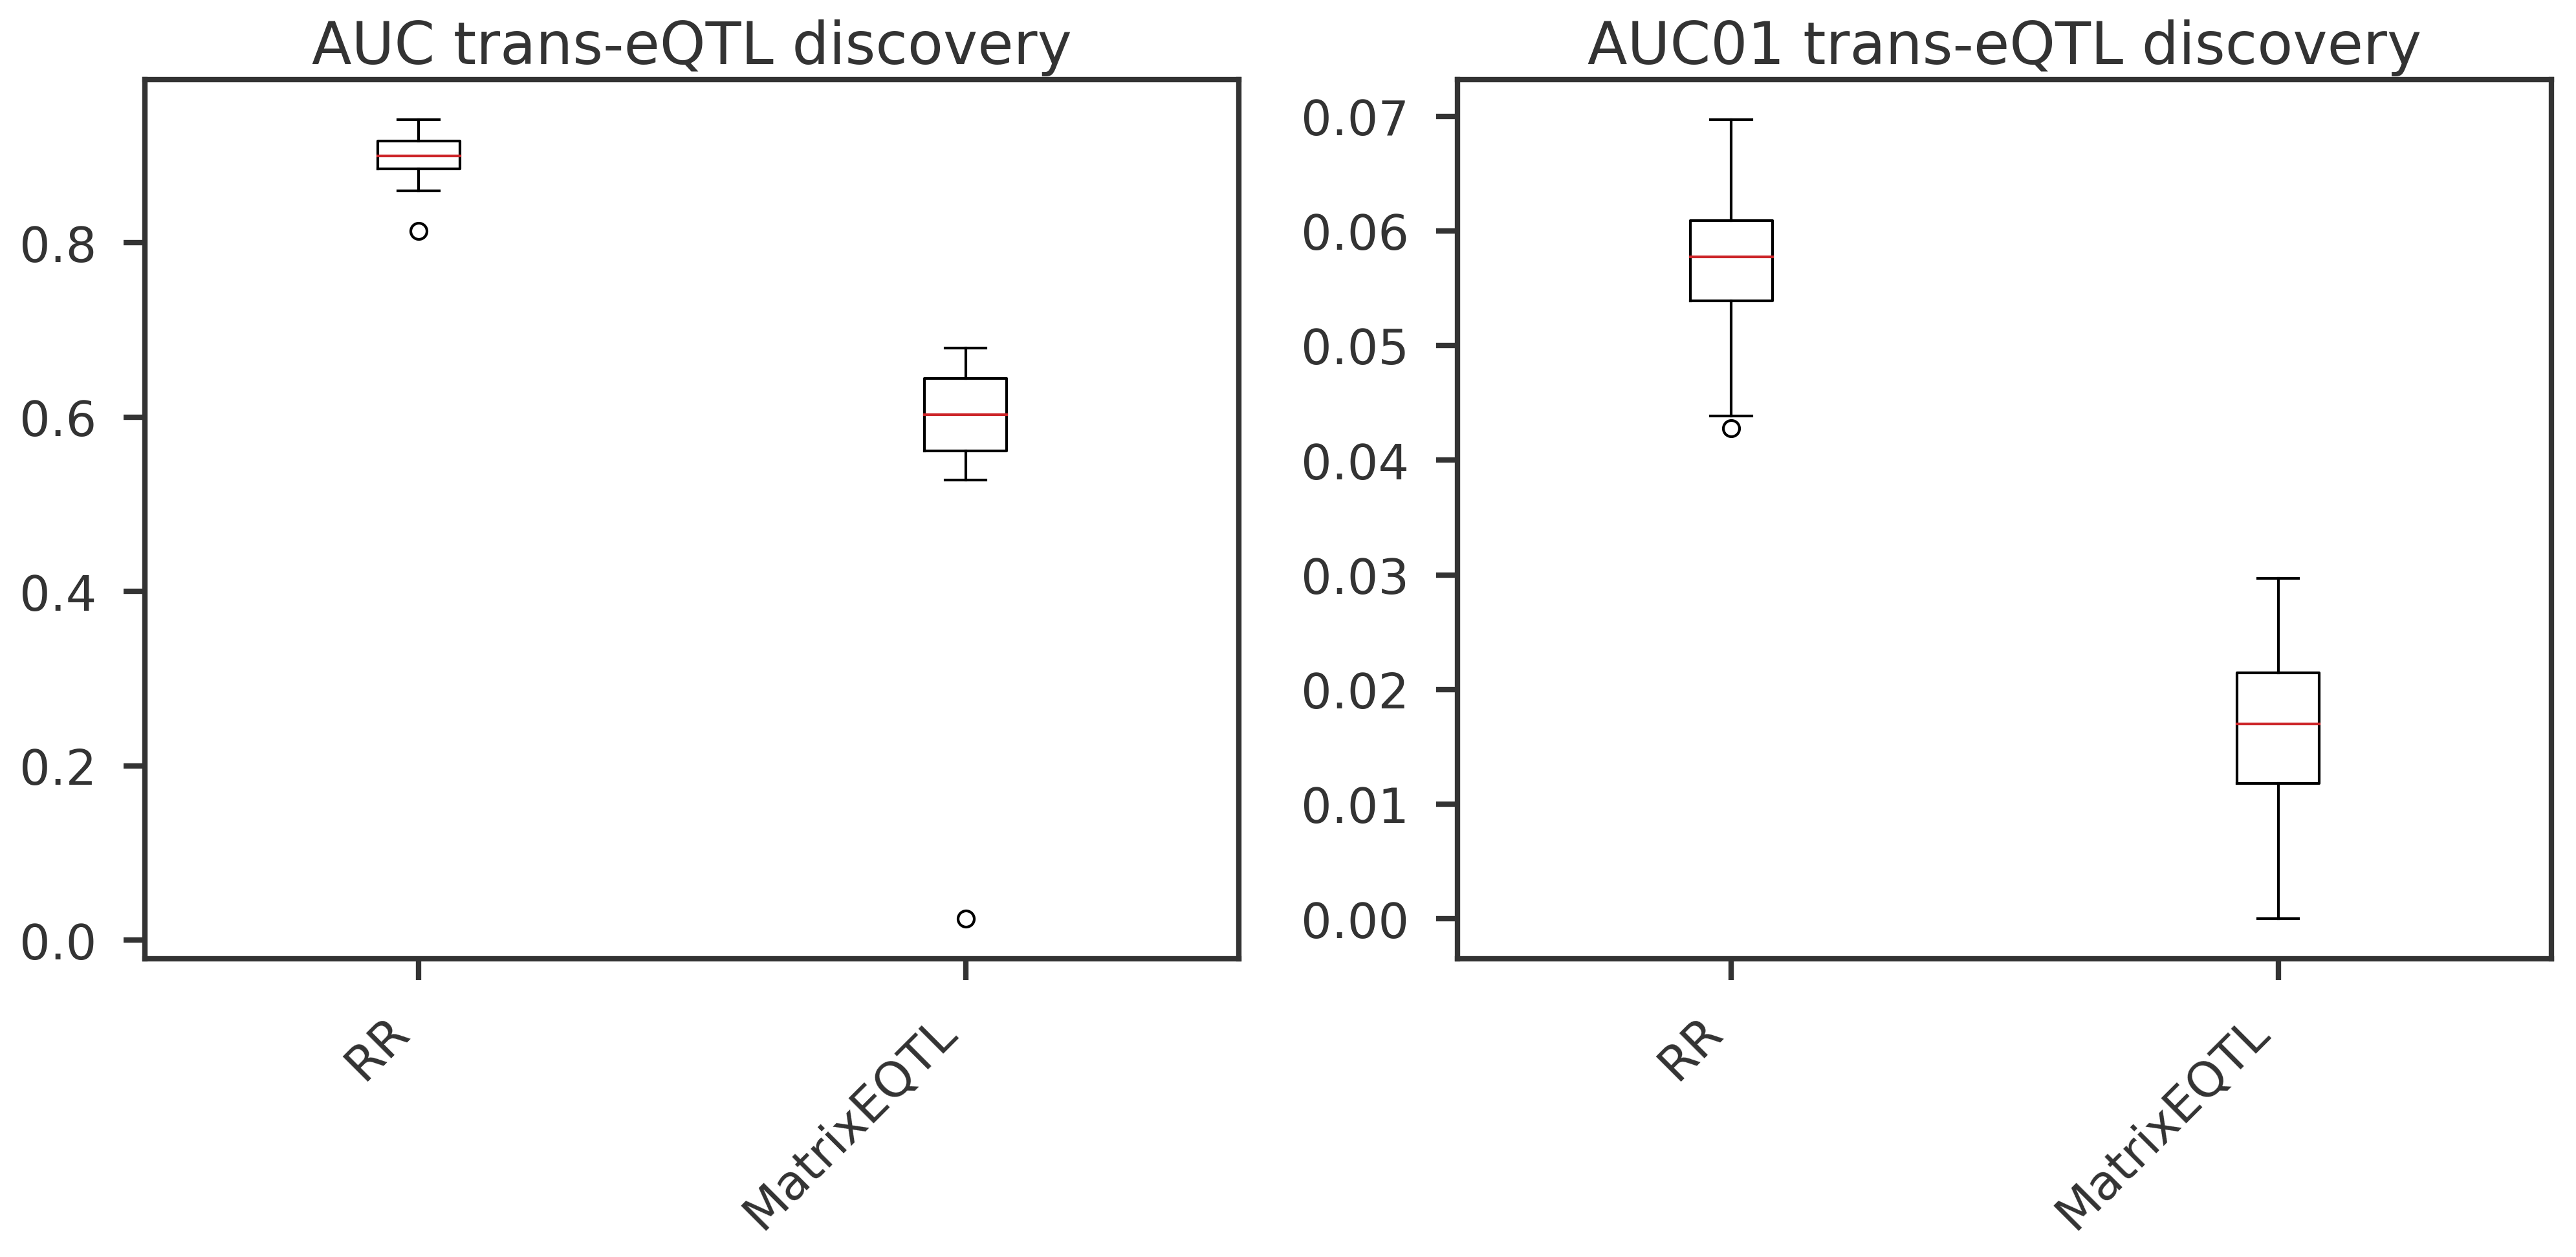

In [106]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.boxplot([list(all_rr['auc']),
             list(all_meqtl['auc'])],
             positions=[1, 2])
ax1.set_xticklabels(labels=["RR", "MatrixEQTL"], rotation = 45, ha="right")
ax1.set_title("AUC trans-eQTL discovery")

ax2.boxplot([list(all_rr['auc01']),
             list(all_meqtl['auc01'])],
             positions=[1, 2])
ax2.set_xticklabels(labels=["RR", "MatrixEQTL"], rotation = 45, ha="right")
ax2.set_title("AUC01 trans-eQTL discovery")


plt.show()

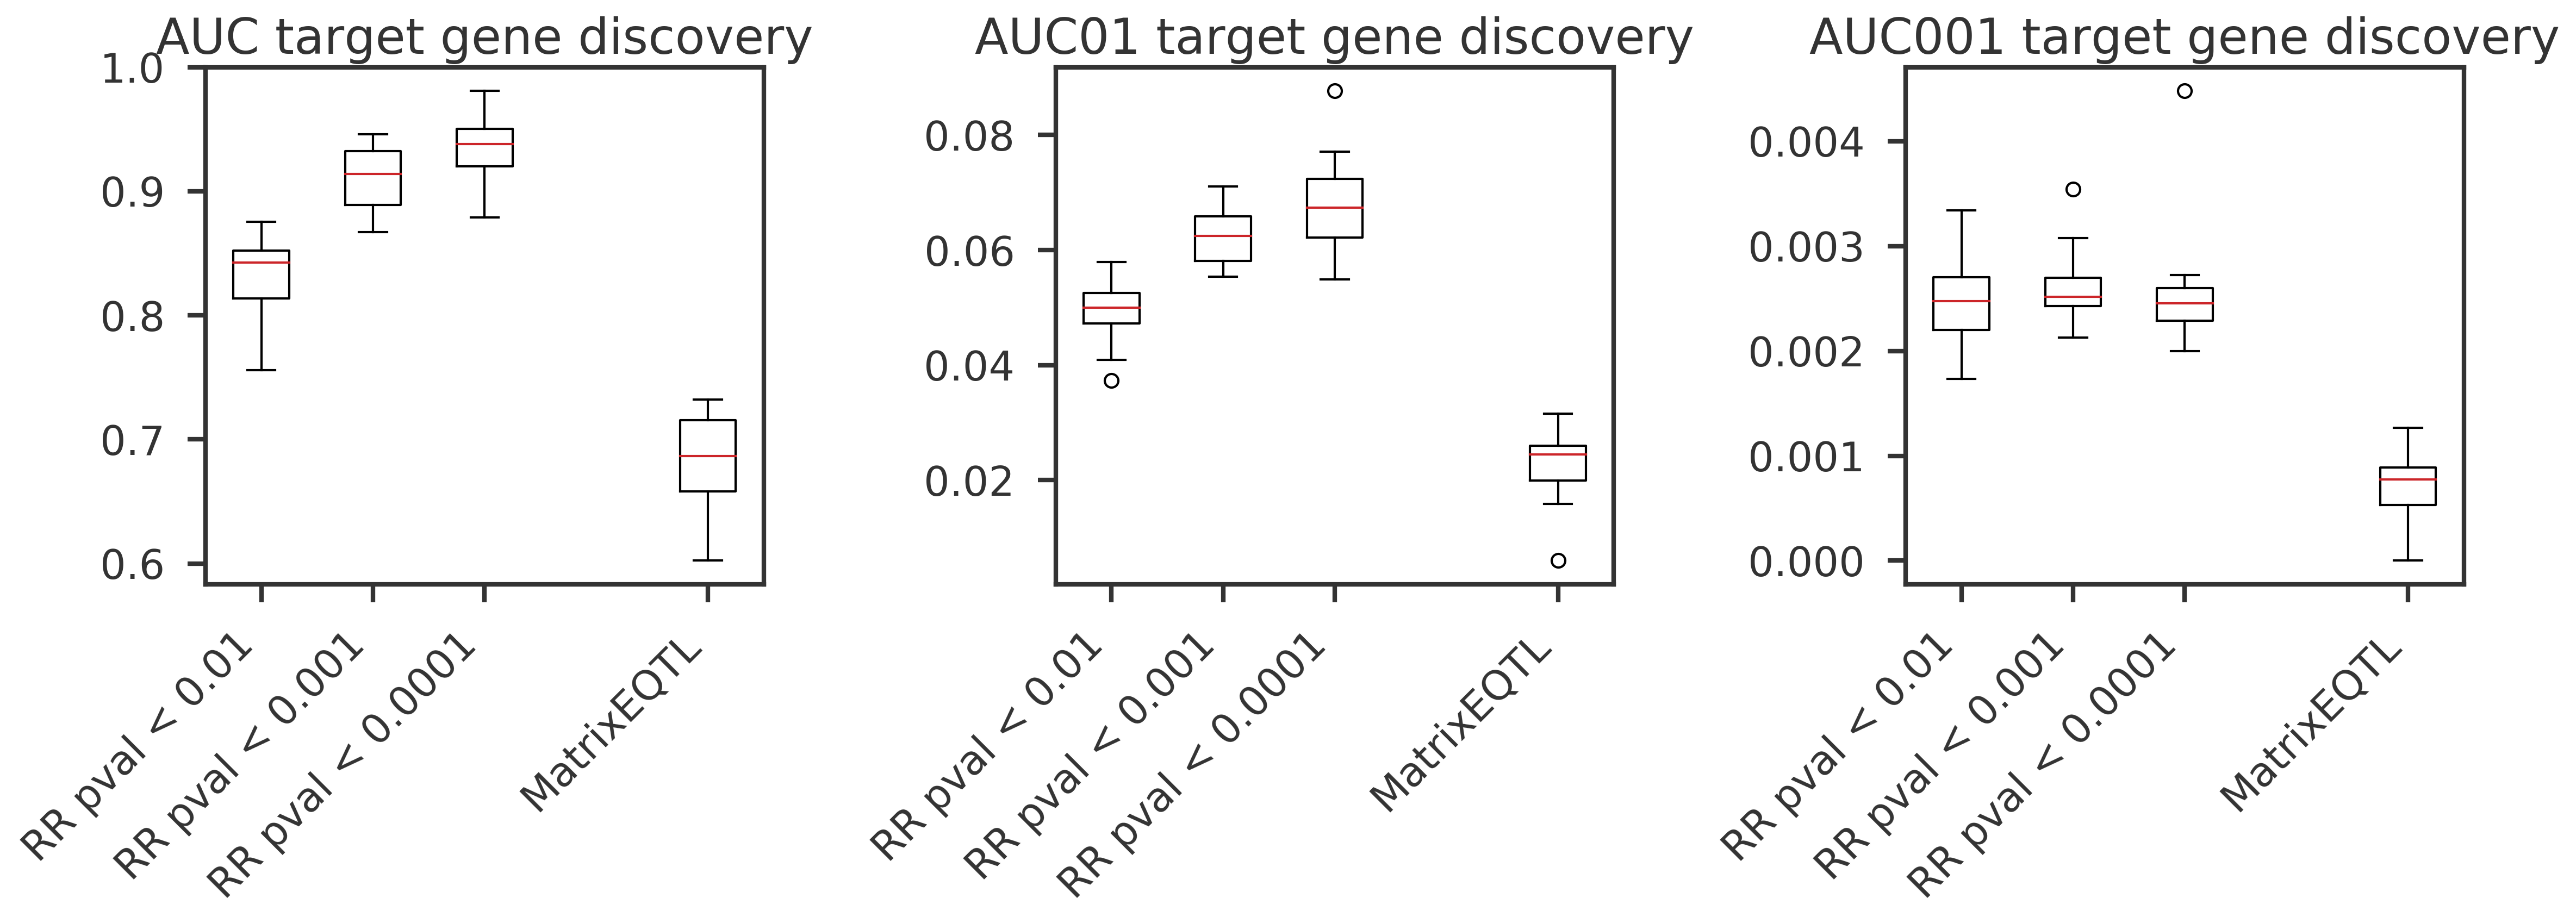

In [107]:
import matplotlib.pyplot as plt
sys.path.append('../../')
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt')


fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.boxplot([list(all_rr_tg.query('cutoff==0.01')['auc']),
             list(all_rr_tg.query('cutoff==0.001')['auc']),
             list(all_rr_tg.query('cutoff==0.0001')['auc']),
             list(all_meqtl_tg['auc'])],
             positions=[1, 2, 3, 5])
ax1.set_xticklabels(labels=["RR pval < 0.01", "RR pval < 0.001", "RR pval < 0.0001", "MatrixEQTL"], rotation = 45, ha="right")
ax1.set_title("AUC target gene discovery")
ax2.boxplot([list(all_rr_tg.query('cutoff==0.01')['auc01']),
             list(all_rr_tg.query('cutoff==0.001')['auc01']),
             list(all_rr_tg.query('cutoff==0.0001')['auc01']),
             list(all_meqtl_tg['auc01'])],
             positions=[1, 2, 3, 5])
ax2.set_xticklabels(labels=["RR pval < 0.01", "RR pval < 0.001", "RR pval < 0.0001", "MatrixEQTL"], rotation = 45, ha="right")
ax2.set_title("AUC01 target gene discovery")
ax3.boxplot([list(all_rr_tg.query('cutoff==0.01')['auc001']),
             list(all_rr_tg.query('cutoff==0.001')['auc001']),
             list(all_rr_tg.query('cutoff==0.0001')['auc001']),
             list(all_meqtl_tg['auc001'])],
             positions=[1, 2, 3, 5])
ax3.set_xticklabels(labels=["RR pval < 0.01", "RR pval < 0.001", "RR pval < 0.0001", "MatrixEQTL"], rotation = 45, ha="right")
ax3.set_title("AUC001 target gene discovery")
plt.tight_layout()
plt.show()


sim001
sim002
sim003


/usr/product/applsw/conda/2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


IndexError: list index out of range

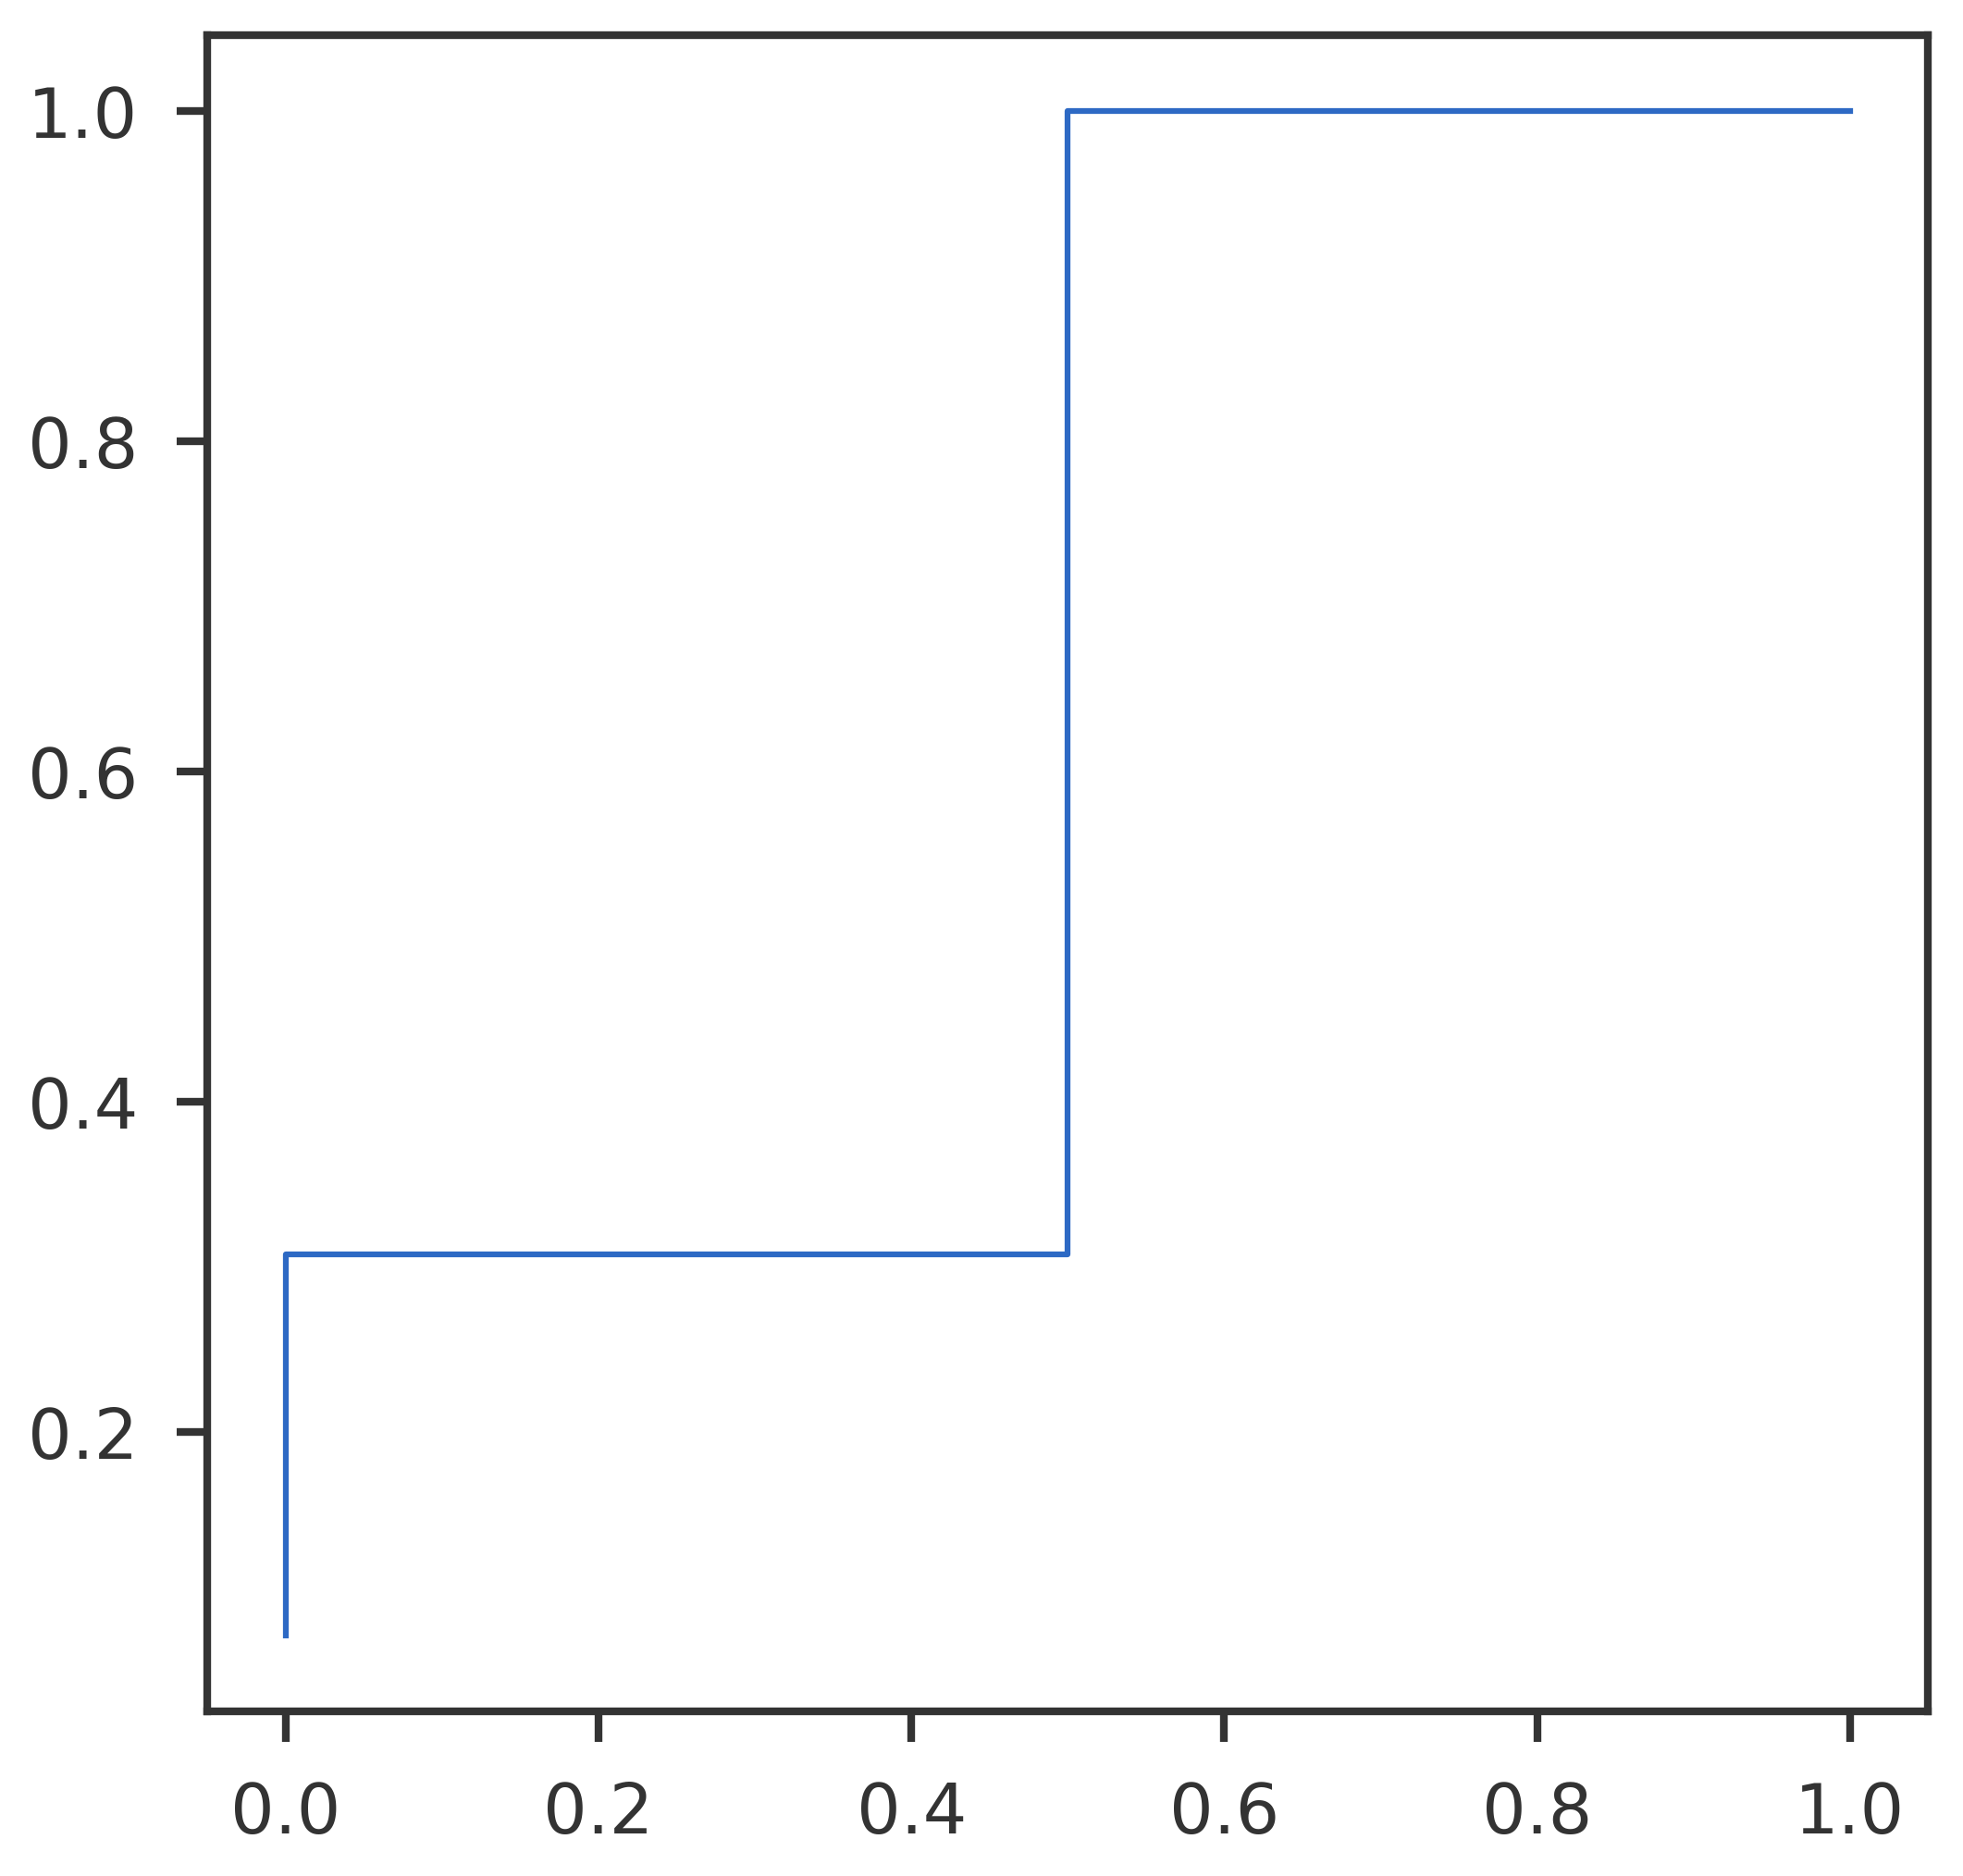

In [75]:
roc_dir = os.path.join(basedir, "rocdata_franco")


fdr_target = 0.1
sb = 0.2
for i in range(1,21):
    simname = "sim{:03d}".format(i)
    print(simname)
    tp = 0
    fp = 0
    tpr = list()
    fpr = list()
    with open(os.path.join(roc_dir, f"rr_target_genes_fdr_bh_{simname}_sb{sb}.txt")) as inst:
        next(inst)
        for line in inst:
            fdr = float(line.rstrip().split()[3])
            if fdr <= fdr_target:
                is_tg = int(line.rstrip().split()[5])
                if is_tg == 1:
                    tp += 1
                else:
                    fp += 1
                tpr.append(tp)
                fpr.append(fp)
    TPR = np.array(tpr) / tpr[-1]
    FPR = np.array(fpr) / fpr[-1]
    plt.plot(FPR, TPR)
plt.show()
            
    

In [84]:
roc_dir = os.path.join(basedir, "rocdata_franco_nocis")

fdr_target = 0.1
sb = 0.2
for i in range(1,21):
    simname = "sim{:03d}".format(i)
    tp = 0
    fp = 0
    tpr = list()
    fpr = list()
    with open(os.path.join(roc_dir, f"rr_target_genes_fdr_bh_{simname}_sb{sb}.txt")) as inst:
        next(inst)
        for line in inst:
            fdr = float(line.rstrip().split()[3])
            if fdr <= fdr_target:
                is_tg = int(line.rstrip().split()[5])
                if is_tg == 1:
                    tp += 1
                else:
                    fp += 1
                tpr.append(tp)
                fpr.append(fp)
    if len(tpr) == 0:
        continue
#     TPR = np.array(tpr) / tpr[-1]
#     FPR = np.array(fpr) / fpr[-1]
    print(f"{simname} - TP:{tpr[-1]}, FP: {fpr[-1]}")
#     plt.plot(FPR, TPR)
# plt.show()

sim001 - TP:13, FP: 2
sim002 - TP:0, FP: 1
sim004 - TP:11, FP: 0
sim005 - TP:12, FP: 2
sim006 - TP:2, FP: 3
sim008 - TP:2, FP: 0
sim009 - TP:3, FP: 0
sim010 - TP:10, FP: 0
sim011 - TP:6, FP: 2
sim012 - TP:13, FP: 1
sim013 - TP:3, FP: 0
sim014 - TP:0, FP: 2
sim015 - TP:5, FP: 3
sim016 - TP:0, FP: 1
sim017 - TP:2, FP: 0
sim018 - TP:2, FP: 2
sim019 - TP:3, FP: 0


In [71]:
print(tpr[-1])
print(fpr[-1])

107
738
